### Analysis Overview
Mar2025
1. Calculate social cohesion scores and append to dataset  
2. Data prep  
3. Main models  
4. Robustness check  
5. Heterogeneity effects

#### Datasets
1. Visit patterns joined with US Spending data  
2. Income data from ACS  
3. Race data from ACS  
4. POI locations
5. GLX Geodata

In [1]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from sklearn.linear_model import Lasso
import xgboost as xgb
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from statsmodels.formula.api import ols
import geojson
import geopandas as gpd
import pandas as pd
from datetime import timedelta 
from functools import reduce
import statsmodels.api as sm
pd.set_option('display.max_columns', None)
from linearmodels import PanelOLS

# from warnings import filterwarnings
# filterwarnings('ignore')  # option: it will suppress all warnings


In [2]:
#Load data
df_main = pd.read_csv(r"input_data/visiting_pattern.csv") # POI data
df_cen_ma = pd.read_csv(r"input_data/census_ma_income.csv") #Income data
df_race_ma = pd.read_csv(r"input_data/census_ma_race.csv") #Race data

#Geodata
stations = gpd.read_file(r"input_data/GLXNODE.geojson")
stores = gpd.read_file(r'input_data/POIs.geojson')
stations = stations.to_crs('EPSG:3857')
stores = stores.to_crs('EPSG:3857')

df_main.head(5)

/tmp/ipykernel_566643/3024496906.py:2: DtypeWarning: Columns (3,4,6,19,29,100) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv(r"input_data/visiting_pattern.csv") # POI data


,Unnamed: 0.1,Unnamed: 0,PLACEKEY,PARENT_PLACEKEY_x,SAFEGRAPH_BRAND_IDS_x,LOCATION_NAME_x,BRANDS_x,STORE_ID_x,TOP_CATEGORY_x,SUB_CATEGORY_x,NAICS_CODE_x,LATITUDE_x,LONGITUDE_x,STREET_ADDRESS_x,CITY_x,REGION_x,POSTAL_CODE_x,OPEN_HOURS_x,CATEGORY_TAGS_x,OPENED_ON_x,CLOSED_ON_x,TRACKING_CLOSED_SINCE_x,WEBSITES,GEOMETRY_TYPE_x,POLYGON_WKT_x,POLYGON_CLASS_x,ENCLOSED_x,PHONE_NUMBER_x,IS_SYNTHETIC_x,INCLUDES_PARKING_LOT_x,ISO_COUNTRY_CODE_x,WKT_AREA_SQ_METERS_x,DATE_RANGE_START,DATE_RANGE_END,RAW_VISIT_COUNTS,RAW_VISITOR_COUNTS,VISITS_BY_DAY,VISITS_BY_EACH_HOUR,POI_CBG,VISITOR_HOME_CBGS,VISITOR_HOME_AGGREGATION,VISITOR_DAYTIME_CBGS,VISITOR_COUNTRY_OF_ORIGIN,DISTANCE_FROM_HOME,MEDIAN_DWELL,BUCKETED_DWELL_TIMES,RELATED_SAME_DAY_BRAND,RELATED_SAME_WEEK_BRAND,DEVICE_TYPE,NORMALIZED_VISITS_BY_TOTAL_VISITORS,geometry_x,in1km_x,VISIT_BY_DAY_list,date_xh,date_xhd,dow_x,tract,population,income,poverty_ratio,lessedu_ratio,female_ratio,white_ratio,black_ratio,asian_ratio,walk_work,transit_work,drive_work,SPEND_DATE_RANGE_START_x,SPEND_DATE_RANGE_END_x,RAW_TOTAL_SPEND_x,RAW_NUM_TRANSACTIONS_x,RAW_NUM_CUSTOMERS_x,MEDIAN_SPEND_PER_TRANSACTION_x,MEDIAN_SPEND_PER_CUSTOMER_x,SPEND_PER_TRANSACTION_PERCENTILES_x,SPEND_BY_DAY_x,SPEND_PER_TRANSACTION_BY_DAY_x,SPEND_BY_DAY_OF_WEEK_x,SPEND_PCT_CHANGE_VS_PREV_MONTH_x,SPEND_PCT_CHANGE_VS_PREV_YEAR_x,ONLINE_TRANSACTIONS_x,ONLINE_SPEND_x,TRANSACTION_INTERMEDIARY_x,SPEND_BY_TRANSACTION_INTERMEDIARY_x,BUCKETED_CUSTOMER_FREQUENCY_x,MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY_x,BUCKETED_CUSTOMER_INCOMES_x,MEAN_SPEND_PER_CUSTOMER_BY_INCOME_x,CUSTOMER_HOME_CITY_x,RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT_x,RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT_x,RELATED_CROSS_SHOPPING_SAME_CATEGORY_BRANDS_PCT_x,RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT_x,RELATED_WIRELESS_CARRIER_PCT_x,RELATED_STREAMING_CABLE_PCT_x,RELATED_DELIVERY_SERVICE_PCT_x,RELATED_RIDESHARE_SERVICE_PCT_x,RELATED_BUYNOWPAYLATER_SERVICE_PCT_x,RELATED_PAYMENT_PLATFORM_PCT_x,BRANDS_x.1,DOMAINS,WEBSITE,date,VISIT_BY_DAY_normalized
0,0,0,223-222@62j-sz8-gtv,NaN,NaN,Wellington's Pizzeria,NaN,NaN,Restaurants and Other Eating Places,Full-Service Restaurants,722511,42.418166,-71.108893,22 Riverside Ave,Medford,MA,2155.0,"{ ""Mon"": [[""11:00"", ""22:00""]], ""Tue"": [[""11:00...","Italian Food,Pizza",NaN,NaN,2019-07-01 00:00:00.000,wellingtonspizzeria.com,POLYGON,POLYGON ((-71.1089471639325 42.418119505802615...,OWNED_POLYGON,False,1.781391e+10,False,False,US,65.0,2022-05-30 00:00:00.000,2022-06-06 00:00:00.000,10.0,9.0,"[3,2,0,1,1,2,1]","[0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0...",250173391004,"{""250173563006"":4}","{""25017356300"":4,""25017339100"":4}","{""250173391001"":4}","{""US"":9}",3260.0,5.0,"{ ""<5"":9, ""5-20"":1, ""21-60"":0, ""61-240"":0, "">2...","{""Lifestance Health"":2,""Mass General Brigham"":...","{""CVS"":6,""Western Union"":6,""Starbucks"":5,""Targ...","{""ios"":8}",0.000044,POINT (232189.47499430945 907590.3078673852),False,0,2022-06-01,2022-06-01,3,25017339100,6504,40.07,0.074266,0.087952,0.539053,0.886839,0.030443,0.03198,0.028395,0.125617,0.663272,2022-06-01 00:00:00.000,2022-07-01 00:00:00.000,49.47,2,2,24.74,24.74,"{""25"":22.45,""75"":27.02}",0.00,0.00,"{""Monday"":0.00,""Tuesday"":0.00,""Wednesday"":27.0...",NaN,NaN,0,0.0,"{""No intermediary"":2}","{""No intermediary"":49.47}","{""1"":2,""2"":0,""3"":0,""4"":0,""5-10"":0,"">10"":0}","{""1"":24.74,""2"":null,""3"":null,""4"":null,""5-10"":n...","{""60-75k"":2,""100-150k"":3}","{""60-75k"":27.02,""100-150k"":22.45}","{""Erda, UT"":2,""Medford, MA"":2}","{""Star Market"":50,""L.L.Bean"":50,""Trader Joe's""...","{""Uber"":50,""Amazon"":50,""Delta Air Lines"":50,""N...","{""The Boiling Crab"":50,""B.GOOD"":50,""Starbucks""...","{""Target"":50,""Wegmans Food Markets"":50,""Whole ...","{""Verizon Wireless"":50}","{""Netflix"":50}",{},"{""Uber"":50}",{},{},NaN,"""[\""wellingtonspizzeria.com\""]""",http://www.wellingtonspizzeria.com/,2022-06-01,-0.292587
1,1,1,223-222@62j-sz8-gtv,NaN,NaN,Wellin

## 01 Calculate social cohesion indices and append to dataset

In [3]:
df_cen_ma['tractid'] = df_cen_ma['tractid'].astype(str)

df_race_ma['tractid'] = df_race_ma['tractid'].astype(str)

df_convert = df_main[df_main["VISITOR_HOME_AGGREGATION"].notna()]
df_convert["VISITOR_HOME_AGGREGATION"] = df_convert["VISITOR_HOME_AGGREGATION"].apply(ast.literal_eval)

/tmp/ipykernel_566643/1076065845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_convert["VISITOR_HOME_AGGREGATION"] = df_convert["VISITOR_HOME_AGGREGATION"].apply(ast.literal_eval)


In [4]:
def calculate_segregation(target_df, ref_ef, col_of_interest,newcol_name): 
    target_df = target_df.groupby(['PLACEKEY', 'DATE_RANGE_START'],as_index=False).first()
    scores = []
    for i,x in tqdm(enumerate(target_df[col_of_interest])):
        quantile1 = 0
        quantile2 = 0
        quantile3 = 0
        quantile4 = 0
        for key, value in x.items():
            if (key[:2] == '25'):
                quantile = ref_ef.loc[ref_ef['tractid'] == key, 'quantile_category'].values[0] 
                if quantile == 1:
                    quantile1 = quantile1 + value
                if quantile == 2:
                    quantile2 = quantile2 + value
                if quantile == 3:
                    quantile3 = quantile3 + value
                if quantile == 4:
                    quantile4 = quantile4 + value
        sum = quantile1 + quantile2 + quantile3 + quantile4

        if sum != 0:
            S = abs(quantile1/sum - 1/4) + abs(quantile2/sum - 1/4) + abs(quantile3/sum - 1/4) + abs(quantile4/sum - 1/4)
            s = S*2/3
        else:
            s = np.nan
        scores = scores + [s]
    target_df[newcol_name] = scores
    return target_df

In [5]:
df_income = calculate_segregation(df_convert, df_cen_ma, "VISITOR_HOME_AGGREGATION", "income_seg")
df_income_race = calculate_segregation(df_income, df_race_ma, "VISITOR_HOME_AGGREGATION", "race_seg")

33510it [01:55, 289.09it/s] 
33510it [01:51, 301.34it/s] 


In [6]:
df_income_race.dropna(subset=['income_seg','race_seg'])
df_income_race.tail(5)

,PLACEKEY,DATE_RANGE_START,Unnamed: 0.1,Unnamed: 0,PARENT_PLACEKEY_x,SAFEGRAPH_BRAND_IDS_x,LOCATION_NAME_x,BRANDS_x,STORE_ID_x,TOP_CATEGORY_x,SUB_CATEGORY_x,NAICS_CODE_x,LATITUDE_x,LONGITUDE_x,STREET_ADDRESS_x,CITY_x,REGION_x,POSTAL_CODE_x,OPEN_HOURS_x,CATEGORY_TAGS_x,OPENED_ON_x,CLOSED_ON_x,TRACKING_CLOSED_SINCE_x,WEBSITES,GEOMETRY_TYPE_x,POLYGON_WKT_x,POLYGON_CLASS_x,ENCLOSED_x,PHONE_NUMBER_x,IS_SYNTHETIC_x,INCLUDES_PARKING_LOT_x,ISO_COUNTRY_CODE_x,WKT_AREA_SQ_METERS_x,DATE_RANGE_END,RAW_VISIT_COUNTS,RAW_VISITOR_COUNTS,VISITS_BY_DAY,VISITS_BY_EACH_HOUR,POI_CBG,VISITOR_HOME_CBGS,VISITOR_HOME_AGGREGATION,VISITOR_DAYTIME_CBGS,VISITOR_COUNTRY_OF_ORIGIN,DISTANCE_FROM_HOME,MEDIAN_DWELL,BUCKETED_DWELL_TIMES,RELATED_SAME_DAY_BRAND,RELATED_SAME_WEEK_BRAND,DEVICE_TYPE,NORMALIZED_VISITS_BY_TOTAL_VISITORS,geometry_x,in1km_x,VISIT_BY_DAY_list,date_xh,date_xhd,dow_x,tract,population,income,poverty_ratio,lessedu_ratio,female_ratio,white_ratio,black_ratio,asian_ratio,walk_work,transit_work,drive_work,SPEND_DATE_RANGE_START_x,SPEND_DATE_RANGE_END_x,RAW_TOTAL_SPEND_x,RAW_NUM_TRANSACTIONS_x,RAW_NUM_CUSTOMERS_x,MEDIAN_SPEND_PER_TRANSACTION_x,MEDIAN_SPEND_PER_CUSTOMER_x,SPEND_PER_TRANSACTION_PERCENTILES_x,SPEND_BY_DAY_x,SPEND_PER_TRANSACTION_BY_DAY_x,SPEND_BY_DAY_OF_WEEK_x,SPEND_PCT_CHANGE_VS_PREV_MONTH_x,SPEND_PCT_CHANGE_VS_PREV_YEAR_x,ONLINE_TRANSACTIONS_x,ONLINE_SPEND_x,TRANSACTION_INTERMEDIARY_x,SPEND_BY_TRANSACTION_INTERMEDIARY_x,BUCKETED_CUSTOMER_FREQUENCY_x,MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY_x,BUCKETED_CUSTOMER_INCOMES_x,MEAN_SPEND_PER_CUSTOMER_BY_INCOME_x,CUSTOMER_HOME_CITY_x,RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT_x,RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT_x,RELATED_CROSS_SHOPPING_SAME_CATEGORY_BRANDS_PCT_x,RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT_x,RELATED_WIRELESS_CARRIER_PCT_x,RELATED_STREAMING_CABLE_PCT_x,RELATED_DELIVERY_SERVICE_PCT_x,RELATED_RIDESHARE_SERVICE_PCT_x,RELATED_BUYNOWPAYLATER_SERVICE_PCT_x,RELATED_PAYMENT_PLATFORM_PCT_x,BRANDS_x.1,DOMAINS,WEBSITE,date,VISIT_BY_DAY_normalized,income_seg,race_seg
33505,zzz-222@62j-sjv-d35,2022-11-28 00:00:00.000,197253,197253,None,None,Cambridge Common,None,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190,42.376475,-71.120615,Cambridge Common,Cambridge,MA,2138.0,None,None,None,NaN,2019-07-01 00:00:00.000,None,POLYGON,POLYGON ((-71.11973331274214 42.37555952395291...,OWNED_POLYGON,False,NaN,False,None,US,33225.0,2022-12-05 00:00:00.000,547.0,375.0,"[76,99,73,64,100,63,72]","[0,1,0,0,0,1,1,2,10,4,4,4,1,4,4,4,6,10,7,9,8,1...",250173540003,"{""250173540002"":49,""250173537003"":19,""25017353...","{'25017354000': 58, '25017353700': 31, '250173...","{""250173540002"":39,""250173536005"":33,""25017353...","{""US"":370}",2206.0,27.0,"{ ""<5"":466, ""5-20"":7, ""21-60"":6, ""61-240"":29, ...","{""CVS"":100,""MinuteClinic"":79,""Subway"":74,""Clov...","{""CVS"":209,""Dunkin'"":177,""Western Union"":168,""...","{""ios"":282,""android"":90}",0.002202,POINT (231245.31755214476 902955.0549437144),False,76,2022-11-28,2022-11-28,1,25017354000,4276,29.306,0.191192,0.002319,0.479654,0.733396,0.058232,0.16464,0.371589,0.162841,0.275877,2022-11-01 00:00:00.000,2022-12-01 00:00:00.000,1981.97,31,23,39.29,55.22,"{""25"":23.36,""75"":95.86}",38.35,19.18,"{""Monday"":327.59,""Tuesday"":436.44,""Wednesday"":...",36.0,-15.0,0,0.0,"{""No intermediary"":30,""Apple Pay"":1}","{""No intermediary"":1943.64,""Apple Pay"":38.33}","{""1"":17,""2"":4,""3"":2,""4"":0,""5-10"":0,"">10"":0}","{""1"":60.35,""2"":54.63,""3"":368.80,""4"":null,""5-10...","{""<25k"":3,""45-60k"":2,""60-75k"":2,""75-100k"":4,""1...","{""<25k"":59.12,""45-60k"":25.18,""60-75k"":152.99,""...","{""Cambridge, MA"":9,""Bridgeville, PA"":3,""Lubboc...","{""CVS"":44,""Whole Foods Market"":40,""Target"":31,...","{""Amazon"":57,""Apple"":48,""Uber"":35,""Lyft"":31,""N...",{},"{""CVS"":18,""Star Market"":14,""Whole Foods Market...","{""Verizon Wireless"":22,""AT&T"":9,""T-Mobile"":9,""...","{

In [9]:
# df_income_race.to_csv(r"input_data\df_withincome_race.csv")

## 02 Data prep
1. Assign treatment group
2. Add dummy for treat/control and pre/post
3. Remove outliers

Assign groups

In [7]:
def assign_groups(gdf, buffer_distance):
    stations['buffer'] = stations.geometry.buffer(buffer_distance)
    buffers = gpd.GeoDataFrame(geometry=stations['buffer'], crs=stations.crs)

    gdf = gpd.sjoin(gdf, buffers, how='left', predicate='within')

    gdf['treatment'] = gdf['index_right'].notna().astype(int)
    gdf = gdf.drop(columns=['index_right'])
    return gdf

def add_treatment(df, buffer_distance):
    stores_buffer_change = assign_groups(stores, buffer_distance)
    df = df.drop(['in1km_x'], axis=1)
    df_analysis= df.merge(stores_buffer_change[['PLACEKEY', 'treatment']], on='PLACEKEY', how='left')
    df_analysis = df_analysis.drop_duplicates(subset=['PLACEKEY','date_xh'])
    return df_analysis

In [8]:
df_main_updated =add_treatment(df_main, 1000)

In [9]:
df_income_race_updated = add_treatment(df_income_race, 1500)

Add Treat/Psot dummies

In [10]:
def create_TP_dummy(df_main):
    df_main['date_num'] = (df_main['date_xh'] >= '2022-12-12').astype(int)
    return df_main

In [11]:
df_main_updated = create_TP_dummy(df_main_updated)

In [12]:
df_income_race_updated = create_TP_dummy(df_income_race_updated)

Remove outliers

In [13]:
def remove_outliers(df, var):
    df1 = df.copy()

    data_mean = df1[var].mean()
    data_std = df1[var].std()

    upper_bound = data_mean + 3 * data_std
    lower_bound = data_mean - 3 * data_std
    
    df_outliers = df1[(df1[var] < lower_bound) | (df1[var] > upper_bound)]['PLACEKEY'].unique().tolist()
    df_cleaned = df1[~df1['PLACEKEY'].isin(df_outliers )]

    return df_cleaned

In [14]:
income_cleaned = remove_outliers(df_income_race_updated, "income_seg").dropna(subset="income_seg")
race_cleaned = remove_outliers(df_income_race_updated, "race_seg").dropna(subset="race_seg")

In [15]:
main_cleaned = remove_outliers(df_main_updated, "VISIT_BY_DAY_list")

In [17]:
def draw_trend_month(df, x_var, y_var):
    df['date_xh'] = pd.to_datetime(df['date_xh'])

    fig, ax = plt.subplots(figsize=(8, 5))

    treated = df[(df[x_var] == 1)]
    control = df[(df[x_var] == 0)]

    covs = []

    treated['year'] = treated['date_xh'].dt.year
    treated['month'] = treated['date_xh'].dt.month
    control['year'] = control['date_xh'].dt.year
    control['month'] = control['date_xh'].dt.month

    treated_avg = treated.groupby(['year', 'month'] + covs)[y_var].mean().reset_index()
    control_avg = control.groupby(['year', 'month'] + covs)[y_var].mean().reset_index()

    treated_avg['plot_date'] = pd.to_datetime(treated_avg[['year', 'month']].assign(day=1))
    control_avg['plot_date'] = pd.to_datetime(control_avg[['year', 'month']].assign(day=1))

    plt.plot(treated_avg['plot_date'], treated_avg[y_var], label='Treated', linewidth=0.8, marker='.', ms=3,
             color='#003f7d')
    plt.plot(control_avg['plot_date'], control_avg[y_var], label='Control', linewidth=0.8, marker='.', ms=3,
             color='#ea8a7a')

    plt.axvline(x=pd.to_datetime('2022-12-12'), color='r', linewidth=0.8, linestyle='--', label='GLX opening')

    plt.xlabel('Time')
    plt.ylabel('Average Daily Visits')
    plt.xticks(rotation=30, fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(fontsize=12, markerscale=1.5)
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightgray',alpha = 0.5)

    plt.rcParams.update({ 
    'font.family': 'Serif'
    })

    fig.patch.set_facecolor('white')
    plt.show()

In [21]:
def calculate_before_after_means(df, date_column='date_xh', treatment_date='2022-12-12', value_column='VISIT_BY_DAY_list', group_column='PLACEKEY'):
  
  df[date_column] = pd.to_datetime(df[date_column])
  df['before'] = df[date_column] < pd.to_datetime(treatment_date)

  means = df.groupby([group_column, 'before'])[value_column].mean().reset_index()
  means = means.pivot(index=group_column, columns='before', values=value_column).reset_index()
  means.columns = [group_column, 'before_mean', 'after_mean']
  return means

In [22]:
result_df = calculate_before_after_means(main_cleaned)
print(result_df)

                PLACEKEY  before_mean  after_mean
0    222-222@62j-sgg-gkz     4.386667    1.278689
1    222-222@62j-sgg-kfz     8.457143    3.678756
2    222-222@62j-sj2-bzf    12.800000   15.545455
3    222-222@62j-sj2-snq     8.204082    3.346535
4    222-222@62j-sj2-t35     3.932773    0.500000
..                   ...          ...         ...
854  zzy-228@62j-sk2-vs5    29.673469   41.430052
855  zzy-229@62j-sk2-vs5     4.451613    1.043956
856  zzy-22b@62j-sk2-vmk    11.020408    5.829016
857  zzy-22d@62j-sj4-vmk    94.743119  111.352332
858  zzz-222@62j-sjv-d35    40.450000   82.621762

[859 rows x 3 columns]


In [23]:
stores_diff_means = stores.merge(result_df, how='inner',on='PLACEKEY') #the preliminary results of difference in means

## 03 Main analysis
### 3.1 Parallel trend

In [16]:
def draw_trend_visit(df, x_var, y_var):

    fig, ax = plt.subplots(figsize=(8, 5))

    treated = df[(df[x_var] == 1)]
    control = df[(df[x_var] == 0)]

    covs = []

    treated_avg = treated.groupby(['DATE_RANGE_START']+covs)[y_var].mean().reset_index()
    control_avg = control.groupby(['DATE_RANGE_START']+covs)[y_var].mean().reset_index()

    plt.plot(pd.to_datetime(treated_avg['DATE_RANGE_START']), treated_avg[y_var], label='Treated', linewidth = 0.8, marker='.',ms=3, color = '#003f7d')
    plt.plot(pd.to_datetime(control_avg['DATE_RANGE_START']), control_avg[y_var], label='Control', linewidth = 0.8, marker='.',ms=3, color = '#ea8a7a')

    plt.axvline(x=pd.to_datetime('2022-12-12'), color='r', linewidth = 0.8, linestyle='--',label='GLX opening')

    plt.xlabel('Time')
    plt.ylabel('Average Daily Visits')
    plt.xticks(rotation=30, fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(fontsize=12, markerscale=1.5)
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightgray',alpha = 0.5)

    plt.rcParams.update({
    'font.family': 'Serif'  
    })

    fig.patch.set_facecolor('white')
    plt.show()

In [26]:
def draw_trend_social(df, x_var, y_var, y_label):

    fig, ax = plt.subplots(figsize=(8, 5))

    treated = df[(df[x_var] == 1)]
    control = df[(df[x_var] == 0)]

    covs = []

    treated_avg = treated.groupby(['DATE_RANGE_START']+covs)[y_var].mean().reset_index()
    control_avg = control.groupby(['DATE_RANGE_START']+covs)[y_var].mean().reset_index()

    plt.plot(pd.to_datetime(treated_avg['DATE_RANGE_START']), treated_avg[y_var], label='Treated', linewidth = 0.8, marker='.',ms=3, color = '#003f7d')
    plt.plot(pd.to_datetime(control_avg['DATE_RANGE_START']), control_avg[y_var], label='Control', linewidth = 0.8, marker='.',ms=3, color = '#ea8a7a')

    plt.axvline(x=pd.to_datetime('2022-12-12'), color='r', linewidth = 0.8, linestyle='--',label='GLX opening')

    plt.ylim(0.4, 1)
    plt.xlabel('Time')
    plt.ylabel(y_label)
    plt.xticks(rotation=30, fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(fontsize=12, markerscale=1.5)
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightgray',alpha = 0.5)

    plt.rcParams.update({
    'font.family': 'Serif'
    })

    fig.patch.set_facecolor('white')
    plt.show()

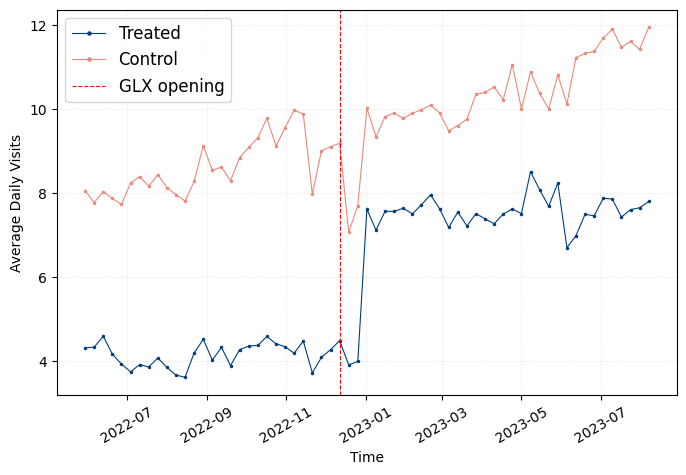

In [27]:
draw_trend_visit(main_cleaned, 'treatment', 'VISIT_BY_DAY_list')

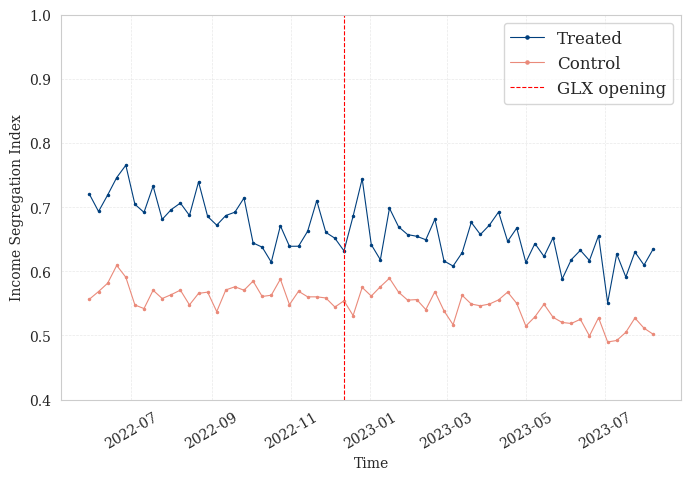

In [22]:
draw_trend_social(income_cleaned, 'treatment', 'income_seg','Income Segregation Index')

### 3.2 Main models

#### 1. DMLDLD

- 2 fold CV

In [ ]:
def dmldid(df,x_var,y_var,learning_rates):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    time_dummies = pd.get_dummies(df[['year', 'month']].astype(str))

    df['year'] = df['year'].astype('category')
    df['month'] = df['month'].astype('category')
    df['day'] = df['day'].astype('category')
    df = pd.get_dummies(df, columns=['year', 'month'])

    att_list = []
    p_values = []
    treatment_effects_all = [] 
    aic_values = []
    bic_values = []
    rmse_values = []

    X_1 = pd.concat([df[['population', "income", "poverty_ratio", "female_ratio", "white_ratio", "black_ratio", "asian_ratio", "walk_work", "transit_work", "drive_work", "SPEND_BY_DAY_x", "SPEND_PER_TRANSACTION_BY_DAY_x"]]], axis=1)

    X_2 = pd.concat([df[['population', "income", "poverty_ratio", "female_ratio", "white_ratio", "black_ratio", "asian_ratio", "walk_work", "transit_work", "drive_work", "SPEND_BY_DAY_x", "SPEND_PER_TRANSACTION_BY_DAY_x"]], time_dummies], axis=1)

    df_set = train_test_split(df, random_state=0, test_size=0.5)

    for lr in learning_rates:
        print(f"Now test learning rate: {lr}, outcome variable: {y_var}:")

        for fold in range(2):
            k = 0 if fold == 0 else 1
            c = 1 if fold == 0 else 0

            eps = 0.03
            treatment_date = '2022-12-12'
            
            df_set[c]['date_xh'] = pd.to_datetime(df_set[c]['date_xh'])
            xgb_model = xgb.XGBRegressor(learning_rate=lr).fit(df_set[c][df_set[c]['date_xh'] < pd.to_datetime(treatment_date)]
            [X_1.columns], df_set[c][df_set[c]['date_xh'] < pd.to_datetime(treatment_date)][x_var])
            g_k_test = np.clip(xgb_model.predict(df_set[k][X_1.columns]), eps, 1 - eps)

            # Calculate metrics for propensity score model
            y_pred_prop = xgb_model.predict(df_set[c][df_set[c]['date_xh'] < pd.to_datetime(treatment_date)][X_1.columns])
            n = len(y_pred_prop)
            k_params = len(xgb_model.get_booster().feature_names)
            residuals_prop = df_set[c][df_set[c]['date_xh'] < pd.to_datetime(treatment_date)][x_var] - y_pred_prop
            sse_prop = np.sum(residuals_prop**2)
            aic_prop = n * np.log(sse_prop/n) + 2 * k_params
            bic_prop = n * np.log(sse_prop/n) + k_params * np.log(n)
            rmse_prop = np.sqrt(sse_prop/n)
            
            aic_values.append(aic_prop)
            bic_values.append(bic_prop)
            rmse_values.append(rmse_prop)

            cv_scores = cross_val_score(xgb_model, df_set[k][X_2.columns], df_set[k][x_var], cv=5, scoring='r2')
            print(f"Cross-validation R-squared: {cv_scores}")
            print(f"Cross-validation R-squared Mean: {cv_scores.mean()}")

            df_before_after_test = pd.DataFrame(columns=['PLACEKEY', 'Y_0', 'Y_1'])

            for placekey in df_set[k]['PLACEKEY'].unique():
                df_individual = df_set[k][df_set[k]['PLACEKEY'] == placekey]
                df_individual_before = df_individual[df_individual['date_num'] == 0]
                df_individual_after = df_individual[df_individual['date_num'] == 1]
                Y_0 = df_individual_before[y_var].mean()
                Y_1 = df_individual_after[y_var].mean()
                g_k_individual = g_k_test[df_set[k]['PLACEKEY'] == placekey].mean()
                D_individual = df_set[k][x_var][df_set[k]['PLACEKEY'] == placekey].mean()

                X_2_means = df_individual[X_2.columns].mean()

                df_before_after_test = df_before_after_test._append({'PLACEKEY': placekey, 'Y_0': Y_0, 'Y_1': Y_1, 'g_k': g_k_individual, 'D': D_individual, **X_2_means}, ignore_index=True)

            df_before_after_test = df_before_after_test.dropna()

            control_outcome = df_before_after_test[df_before_after_test['D'] == 0]['Y_1'] - df_before_after_test[df_before_after_test['D'] == 0]['Y_0']

            outcome_model = xgb.XGBRegressor(learning_rate=lr).fit(df_before_after_test[df_before_after_test['D'] == 0][X_2.columns], control_outcome)
            l_k_test = outcome_model.predict(df_set[k][X_2.columns])

            # Calculate metrics for outcome model
            y_pred_outcome = outcome_model.predict(df_before_after_test[df_before_after_test['D'] == 0][X_2.columns])
            n_outcome = len(y_pred_outcome)
            k_params_outcome = len(outcome_model.get_booster().feature_names)
            residuals_outcome = control_outcome - y_pred_outcome
            sse_outcome = np.sum(residuals_outcome**2)
            aic_outcome = n_outcome * np.log(sse_outcome/n_outcome) + 2 * k_params_outcome
            bic_outcome = n_outcome * np.log(sse_outcome/n_outcome) + k_params_outcome * np.log(n_outcome)
            rmse_outcome = np.sqrt(sse_outcome/n_outcome)
            
            aic_values.append(aic_outcome)
            bic_values.append(bic_outcome)
            rmse_values.append(rmse_outcome)

            cv_scores = cross_val_score(outcome_model, df_set[k][X_2.columns], df_set[k][y_var], cv=5, scoring='r2')
            print(f"Cross-validation R-squared: {cv_scores}")
            print(f"Cross-validation R-squared Mean: {cv_scores.mean()}")

            p_k_test = np.mean(df_set[k][x_var])

            df_before_after_test = pd.DataFrame(columns=['PLACEKEY', 'Y_0', 'Y_1'])

            for placekey in df_set[k]['PLACEKEY'].unique():
                df_individual = df_set[k][df_set[k]['PLACEKEY'] == placekey]
                df_individual_before = df_individual[df_individual['date_num'] == 0]
                df_individual_after = df_individual[df_individual['date_num'] == 1]
                Y_0 = df_individual_before[y_var].mean()
                Y_1 = df_individual_after[y_var].mean()
                g_k_individual = g_k_test[df_set[k]['PLACEKEY'] == placekey].mean()
                l_k_individual = l_k_test[df_set[k]['PLACEKEY'] == placekey].mean()
                D_individual = df_set[k][x_var][df_set[k]['PLACEKEY'] == placekey].mean()

                X_2_means = df_individual[X_2.columns].mean()

                df_before_after_test = df_before_after_test._append({'PLACEKEY': placekey, 'Y_0': Y_0, 'Y_1': Y_1, 'g_k': g_k_individual, 'l_k': l_k_individual, 'D': D_individual, **X_2_means}, ignore_index=True)

            df_before_after_test = df_before_after_test.dropna()

            df_before_after_test['treatment_effect'] = (df_before_after_test['Y_1'] - df_before_after_test['Y_0'] - df_before_after_test['l_k']) / (p_k_test) * (df_before_after_test['D'] - df_before_after_test['g_k']) / (1 - df_before_after_test['g_k'])

            df_before_after_test = df_before_after_test[np.isfinite(df_before_after_test['treatment_effect'])]

            treatment_effects_all.extend(df_before_after_test['treatment_effect'].tolist())

            att_test = df_before_after_test['treatment_effect'].mean()
            att_list.append(att_test)

            t_stat, p_value = stats.ttest_1samp(
                (df_before_after_test['Y_1'] - df_before_after_test['Y_0'] - df_before_after_test['l_k']) / p_k_test *
                (df_before_after_test['D'] - df_before_after_test['g_k']) /
                (1 - df_before_after_test['g_k']), 0)
            p_values.append(p_value)

        final_att = np.mean(att_list)
        att_std = np.std(treatment_effects_all) 
        avg_aic = np.mean(aic_values)
        avg_bic = np.mean(bic_values)
        avg_rmse = np.mean(rmse_values)

        se = att_std / np.sqrt(len(treatment_effects_all))

        ci_lower = final_att - 1.96 * se
        ci_upper = final_att + 1.96 * se

        chi_stat, combined_p_value = stats.combine_pvalues(p_values, method='fisher')

        print('Final ATT:', final_att)
        print('Standard Deviation:', att_std)
        print('Standard Error:', se)
        print('95% Confidence Interval:', [ci_lower, ci_upper])
        print('Combined p-value:', combined_p_value)
        print('Average AIC:', avg_aic)
        print('Average BIC:', avg_bic)
        print('Average RMSE:', avg_rmse)
        
        return {
            'final_att': final_att,
            'att_std': att_std,
            'se': se,
            'ci': [ci_lower, ci_upper],
            'p_value': combined_p_value,
            'aic': avg_aic,
            'bic': avg_bic,
            'rmse': avg_rmse
        }

- 5 fold CV

In [ ]:
def dmldid(df, x_var, y_var, learning_rates):
    # Data preprocessing
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    time_dummies = pd.get_dummies(df[['year', 'month']].astype(str))

    df['year'] = df['year'].astype('category')
    df['month'] = df['month'].astype('category')
    df['day'] = df['day'].astype('category')
    df = pd.get_dummies(df, columns=['year', 'month'])

    # Initialize result containers
    att_list = []
    p_values = []
    treatment_effects_all = []
    aic_values = []
    bic_values = []
    rmse_values = []
    propensity_r2 = []  # Store R² for propensity score model
    outcome_r2 = []     # Store R² for outcome model

    # Define feature sets
    X_1 = df[['population', "income", "poverty_ratio", "female_ratio", 
              "white_ratio", "black_ratio", "asian_ratio", "walk_work", 
              "transit_work", "drive_work", "SPEND_BY_DAY_x", 
              "SPEND_PER_TRANSACTION_BY_DAY_x"]]
              
    X_2 = pd.concat([X_1, time_dummies], axis=1)

    # Create 5 folds for outer cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    folds = list(kf.split(df))

    for lr in learning_rates:
        print(f"\n=== Evaluating learning rate: {lr}, outcome variable: {y_var} ===")

        for fold_idx, (train_idx, test_idx) in enumerate(folds):
            print(f"\nProcessing fold {fold_idx + 1}/5")
            df_train = df.iloc[train_idx]
            df_test = df.iloc[test_idx]

            eps = 0.03
            treatment_date = '2022-12-12'
            
            # ========== Stage 1: Propensity Score Model ==========
            df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])
            train_mask = df_train['date_xh'] < pd.to_datetime(treatment_date)
            
            xgb_model = xgb.XGBRegressor(learning_rate=lr).fit(
                df_train[train_mask][X_1.columns], 
                df_train[train_mask][x_var]
            )
            
            y_pred_prop_train = xgb_model.predict(df_train[train_mask][X_1.columns])
            
            g_k_test = np.clip(xgb_model.predict(df_test[X_1.columns]), eps, 1 - eps)

            # Calculate R2 (on the test set)
            propensity_r2_test = r2_score(
            df_test[x_var], 
            xgb_model.predict(df_test[X_1.columns])
            )

            propensity_r2.append(propensity_r2_test)

            # Calculate metrics for propensity score model
            n = len(y_pred_prop_train)
            k_params = len(xgb_model.get_booster().feature_names)
            residuals_prop = df_train[train_mask][x_var] - y_pred_prop_train
            sse_prop = np.sum(residuals_prop**2)
            aic_prop = n * np.log(sse_prop/n) + 2 * k_params
            bic_prop = n * np.log(sse_prop/n) + k_params * np.log(n)
            rmse_prop = np.sqrt(sse_prop/n)
            
            aic_values.append(aic_prop)
            bic_values.append(bic_prop)
            rmse_values.append(rmse_prop)

            # ========== Stage 2: Outcome Model ==========
            df_before_after_test = pd.DataFrame(columns=['PLACEKEY', 'Y_0', 'Y_1'])

            for placekey in df_test['PLACEKEY'].unique():
                df_individual = df_test[df_test['PLACEKEY'] == placekey]
                df_individual_before = df_individual[df_individual['date_num'] == 0]
                df_individual_after = df_individual[df_individual['date_num'] == 1]
                Y_0 = df_individual_before[y_var].mean()
                Y_1 = df_individual_after[y_var].mean()
                g_k_individual = g_k_test[df_test['PLACEKEY'] == placekey].mean()
                D_individual = df_test[x_var][df_test['PLACEKEY'] == placekey].mean()

                X_2_means = df_individual[X_2.columns].mean()

                df_before_after_test = pd.concat([
                    df_before_after_test,
                    pd.DataFrame([{
                        'PLACEKEY': placekey, 
                        'Y_0': Y_0, 
                        'Y_1': Y_1, 
                        'g_k': g_k_individual, 
                        'D': D_individual, 
                        **X_2_means.to_dict()
                    }])
                ], ignore_index=True)

            df_before_after_test = df_before_after_test.dropna()

            control_outcome = df_before_after_test[df_before_after_test['D'] == 0]['Y_1'] - df_before_after_test[df_before_after_test['D'] == 0]['Y_0']

            outcome_model = xgb.XGBRegressor(learning_rate=lr).fit(
                df_before_after_test[df_before_after_test['D'] == 0][X_2.columns], 
                control_outcome
            )
            
            y_pred_outcome_train = outcome_model.predict(df_before_after_test[df_before_after_test['D'] == 0][X_2.columns])

            l_k_test = outcome_model.predict(df_test[X_2.columns])

            # Calculate R2 (on the test set)
            df_test_control = df_train[df_train[x_var] == 0]  # use x_var instead of D, as D is not yet defined in the orginal set

            if len(df_test_control) > 0:
                actual_diff = (
                    df_test_control[df_test_control['date_num'] == 1]
                    .groupby('PLACEKEY')[y_var].mean() 
                    - df_test_control[df_test_control['date_num'] == 0]
                    .groupby('PLACEKEY')[y_var].mean()
                )
                
                # 删除NaN值（确保actual_diff和pred_diff对齐）
                valid_idx = actual_diff.notna()
                actual_diff_clean = actual_diff[valid_idx]
                
                if len(actual_diff_clean) > 1:  # 至少需要2个样本计算R²
                    pred_diff = outcome_model.predict(
                        df_test_control.groupby('PLACEKEY')[X_2.columns]
                        .mean()
                        .loc[valid_idx]
                    )
                    outcome_r2_test = r2_score(actual_diff_clean, pred_diff)
                else:
                    outcome_r2_test = np.nan
            else:
                outcome_r2_test = np.nan

            outcome_r2.append(outcome_r2_test)

            # Calculate metrics for outcome model
            n_outcome = len(y_pred_outcome_train)
            k_params_outcome = len(outcome_model.get_booster().feature_names)
            residuals_outcome = control_outcome - y_pred_outcome_train
            sse_outcome = np.sum(residuals_outcome**2)
            aic_outcome = n_outcome * np.log(sse_outcome/n_outcome) + 2 * k_params_outcome
            bic_outcome = n_outcome * np.log(sse_outcome/n_outcome) + k_params_outcome * np.log(n_outcome)
            rmse_outcome = np.sqrt(sse_outcome/n_outcome)
            
            aic_values.append(aic_outcome)
            bic_values.append(bic_outcome)
            rmse_values.append(rmse_outcome)

            # ========== Treatment Effect Calculation ==========
            p_k_test = np.mean(df_test[x_var])

            df_before_after_test = pd.DataFrame(columns=['PLACEKEY', 'Y_0', 'Y_1'])

            for placekey in df_test['PLACEKEY'].unique():
                df_individual = df_test[df_test['PLACEKEY'] == placekey]
                df_individual_before = df_individual[df_individual['date_num'] == 0]
                df_individual_after = df_individual[df_individual['date_num'] == 1]
                Y_0 = df_individual_before[y_var].mean()
                Y_1 = df_individual_after[y_var].mean()
                g_k_individual = g_k_test[df_test['PLACEKEY'] == placekey].mean()
                l_k_individual = l_k_test[df_test['PLACEKEY'] == placekey].mean()
                D_individual = df_test[x_var][df_test['PLACEKEY'] == placekey].mean()

                X_2_means = df_individual[X_2.columns].mean()

                df_before_after_test = pd.concat([
                    df_before_after_test,
                    pd.DataFrame([{
                        'PLACEKEY': placekey, 
                        'Y_0': Y_0, 
                        'Y_1': Y_1, 
                        'g_k': g_k_individual, 
                        'l_k': l_k_individual, 
                        'D': D_individual, 
                        **X_2_means.to_dict()
                    }])
                ], ignore_index=True)

            df_before_after_test = df_before_after_test.dropna()

            df_before_after_test['treatment_effect'] = (
                (df_before_after_test['Y_1'] - df_before_after_test['Y_0'] - df_before_after_test['l_k']) / 
                (p_k_test) * 
                (df_before_after_test['D'] - df_before_after_test['g_k']) / 
                (1 - df_before_after_test['g_k'])
            )

            df_before_after_test = df_before_after_test[np.isfinite(df_before_after_test['treatment_effect'])]

            treatment_effects_all.extend(df_before_after_test['treatment_effect'].tolist())

            att_test = df_before_after_test['treatment_effect'].mean()
            att_list.append(att_test)

            # Calculate p-value
            t_stat, p_value = stats.ttest_1samp(
                (df_before_after_test['Y_1'] - df_before_after_test['Y_0'] - df_before_after_test['l_k']) / p_k_test *
                (df_before_after_test['D'] - df_before_after_test['g_k']) /
                (1 - df_before_after_test['g_k']), 0)
            p_values.append(p_value)

        # Calculate final metrics across all folds
        final_att = np.mean(att_list)
        att_std = np.std(treatment_effects_all) 
        avg_aic = np.mean(aic_values)
        avg_bic = np.mean(bic_values)
        avg_rmse = np.mean(rmse_values)
        avg_propensity_r2 = np.mean(propensity_r2)
        avg_outcome_r2 = np.mean(outcome_r2)

        se = att_std / np.sqrt(len(treatment_effects_all))

        ci_lower = final_att - 1.96 * se
        ci_upper = final_att + 1.96 * se

        chi_stat, combined_p_value = stats.combine_pvalues(p_values, method='fisher')

        print('\n=== Final Results ===')
        print('Final ATT:', final_att)
        print('Standard Deviation:', att_std)
        print('Standard Error:', se)
        print('95% Confidence Interval:', [ci_lower, ci_upper])
        print('Combined p-value:', combined_p_value)
        print('\nModel Performance Metrics:')
        print('Average Propensity Score Model R²:', avg_propensity_r2)
        print('Average Outcome Model R²:', avg_outcome_r2)
        print('Average AIC:', avg_aic)
        print('Average BIC:', avg_bic)
        print('Average RMSE:', avg_rmse)
        
        return {
            'final_att': final_att,
            'att_std': att_std,
            'se': se,
            'ci': [ci_lower, ci_upper],
            'p_value': combined_p_value,
            'propensity_r2': avg_propensity_r2,
            'outcome_r2': avg_outcome_r2,
            'aic': avg_aic,
            'bic': avg_bic,
            'rmse': avg_rmse
        }

In [50]:
dmldid(main_cleaned,"treatment","VISIT_BY_DAY_list",[0.05])


=== Evaluating learning rate: 0.05, outcome variable: VISIT_BY_DAY_list ===

Processing fold 1/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 2/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 3/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 4/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 5/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



=== Final Results ===
Final ATT: 1.5583383778376738
Standard Deviation: 21.854226214657903
Standard Error: 0.3431096480349556
95% Confidence Interval: [0.8858434676891609, 2.2308332879861865]
Combined p-value: 5.908971773494917e-05

Model Performance Metrics:
Average Propensity Score Model R²: 0.7229605078697204
Average Outcome Model R²: 0.09804456507561621
Average AIC: -200154.13854013296
Average BIC: -200037.12551451617
Average RMSE: 1.1092408681329864


{'final_att': 1.5583383778376738,
 'att_std': 21.854226214657903,
 'se': 0.3431096480349556,
 'ci': [0.8858434676891609, 2.2308332879861865],
 'p_value': 5.908971773494917e-05,
 'propensity_r2': 0.7229605078697204,
 'outcome_r2': 0.09804456507561621,
 'aic': -200154.13854013296,
 'bic': -200037.12551451617,
 'rmse': 1.1092408681329864}

In [51]:
dmldid(income_cleaned.dropna(subset='income_seg'),"treatment","income_seg",[0.025])


=== Evaluating learning rate: 0.025, outcome variable: income_seg ===

Processing fold 1/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 2/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 3/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 4/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 5/5


/tmp/ipykernel_566643/1837549600.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



=== Final Results ===
Final ATT: 0.00034396984732146973
Standard Deviation: 0.6922258305429675
Standard Error: 0.012526025303817905
95% Confidence Interval: [-0.024207039748161623, 0.02489497944280456]
Combined p-value: 0.9084398533284256

Model Performance Metrics:
Average Propensity Score Model R²: 0.8573235511779785
Average Outcome Model R²: 0.07753743412764998
Average AIC: -20741.804286947383
Average BIC: -20645.285757483955
Average RMSE: 0.12111531603398293


{'final_att': 0.00034396984732146973,
 'att_std': 0.6922258305429675,
 'se': 0.012526025303817905,
 'ci': [-0.024207039748161623, 0.02489497944280456],
 'p_value': 0.9084398533284256,
 'propensity_r2': 0.8573235511779785,
 'outcome_r2': 0.07753743412764998,
 'aic': -20741.804286947383,
 'bic': -20645.285757483955,
 'rmse': 0.12111531603398293}

#### In the following results, the outcome model r2 is calculated based on the training set for the second stage (so not accurate enough)

In [46]:
dmldid(main_cleaned,"treatment","VISIT_BY_DAY_list",[0.05])


=== Evaluating learning rate: 0.05, outcome variable: VISIT_BY_DAY_list ===

Processing fold 1/5


/tmp/ipykernel_566643/3360851207.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 2/5


/tmp/ipykernel_566643/3360851207.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 3/5


/tmp/ipykernel_566643/3360851207.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 4/5


/tmp/ipykernel_566643/3360851207.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 5/5


/tmp/ipykernel_566643/3360851207.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



=== Final Results ===
Final ATT: 1.5583383778376738
Standard Deviation: 21.854226214657903
Standard Error: 0.3431096480349556
95% Confidence Interval: [0.8858434676891609, 2.2308332879861865]
Combined p-value: 5.908971773494917e-05

Model Performance Metrics:
Average Propensity Score Model R²: 0.7229605078697204
Average Outcome Model R²: 0.8956613618612561
Average AIC: -200154.13854013296
Average BIC: -200037.12551451617
Average RMSE: 1.1092408681329864


{'final_att': 1.5583383778376738,
 'att_std': 21.854226214657903,
 'se': 0.3431096480349556,
 'ci': [0.8858434676891609, 2.2308332879861865],
 'p_value': 5.908971773494917e-05,
 'propensity_r2': 0.7229605078697204,
 'outcome_r2': 0.8956613618612561,
 'aic': -200154.13854013296,
 'bic': -200037.12551451617,
 'rmse': 1.1092408681329864}

In [18]:
dmldid(income_cleaned.dropna(subset='income_seg'),"treatment","income_seg",[0.025])


=== Evaluating learning rate: 0.025, outcome variable: income_seg ===

Processing fold 1/5


/tmp/ipykernel_566643/3769068389.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 2/5


/tmp/ipykernel_566643/3769068389.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 3/5


/tmp/ipykernel_566643/3769068389.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 4/5


/tmp/ipykernel_566643/3769068389.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



Processing fold 5/5


/tmp/ipykernel_566643/3769068389.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])



=== Final Results ===
Final ATT: 0.00034396984732146973
Standard Deviation: 0.6922258305429675
Standard Error: 0.012526025303817905
95% Confidence Interval: [-0.024207039748161623, 0.02489497944280456]
Combined p-value: 0.9084398533284256
Average AIC: -20741.804286947383
Average BIC: -20645.285757483955
Average RMSE: 0.12111531603398293


{'final_att': 0.00034396984732146973,
 'att_std': 0.6922258305429675,
 'se': 0.012526025303817905,
 'ci': [-0.024207039748161623, 0.02489497944280456],
 'p_value': 0.9084398533284256,
 'aic': -20741.804286947383,
 'bic': -20645.285757483955,
 'rmse': 0.12111531603398293}

#### 2. Abadie 2005 SDID

In [19]:
def abadie_sdid(df, x_var, y_var):
    df = df.drop_duplicates(subset=['PLACEKEY','date_xh'])
    df = df.dropna(subset=[y_var])
    
    X_1 = pd.concat([df[['population',"income","poverty_ratio","female_ratio","white_ratio",
                        "black_ratio","asian_ratio","walk_work","transit_work","drive_work",
                        "SPEND_BY_DAY_x", "SPEND_PER_TRANSACTION_BY_DAY_x"]]], axis=1)
    
    lasso_model = Lasso()
    
    df_train, df_test = train_test_split(df, random_state=0, test_size=0.5)
    
    eps = 0.03
    treatment_date = '2022-12-12'
    df_train['date_xh'] = pd.to_datetime(df_train['date_xh'])
    
    train_before = df_train[df_train['date_xh'] < pd.to_datetime(treatment_date)]
    lasso_model.fit(train_before[X_1.columns], train_before[x_var])
    
    g_k_test = np.clip(lasso_model.predict(df_test[X_1.columns]), eps, 1 - eps)
    p_k_test = np.mean(df_test[x_var])
    
    # Cross-validation R squared
    cv_scores = cross_val_score(lasso_model, df_test[X_1.columns], df_test[y_var], cv=5, scoring='r2')
    print(f"Cross-validation R-squared: {cv_scores}")
    print(f"Cross-validation R-squared Mean: {cv_scores.mean()}")
    
    # Calculate AIC and BIC
    n = len(train_before)  # number of observations
    k = len(X_1.columns) + 1  # number of parameters (features + intercept)
    
    # Get predictions and residuals
    y_pred = lasso_model.predict(train_before[X_1.columns])
    residuals = train_before[x_var] - y_pred
    rss = np.sum(residuals**2)  # residual sum of squares
    
    # Calculate metrics
    aic = n * np.log(rss/n) + 2 * k
    bic = n * np.log(rss/n) + k * np.log(n)
    rmse = np.sqrt(np.mean(residuals**2))
    
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")
    print(f"RMSE: {rmse}")
    
    df_before_after_test = pd.DataFrame(columns=['PLACEKEY', 'Y_0', 'Y_1'])

    for placekey in df_test['PLACEKEY'].unique():
        df_individual = df_test[df_test['PLACEKEY'] == placekey]
        df_individual_before = df_individual[df_individual['date_num'] == 0]
        df_individual_after = df_individual[df_individual['date_num'] == 1]
        Y_0 = df_individual_before[y_var].mean()
        Y_1 = df_individual_after[y_var].mean()
        g_k_individual = g_k_test[df_test['PLACEKEY'] == placekey].mean()
        D_individual = df_test[x_var][df_test['PLACEKEY'] == placekey].mean()
        
        df_before_after_test = df_before_after_test._append({
            'PLACEKEY': placekey, 
            'Y_0': Y_0, 
            'Y_1': Y_1, 
            'g_k': g_k_individual, 
            'D': D_individual
        }, ignore_index=True)
    
    df_before_after_test = df_before_after_test.dropna()

    df_before_after_test['treatment_effect'] = (
        (df_before_after_test['Y_1'] - df_before_after_test['Y_0']) / (p_k_test) * 
        (df_before_after_test['D'] - df_before_after_test['g_k']) / 
        (1 - df_before_after_test['g_k'])
    )

    df_before_after_test = df_before_after_test[np.isfinite(df_before_after_test['treatment_effect'])]

    att_test = df_before_after_test['treatment_effect'].mean()

    influence_function = (
        (df_before_after_test['Y_1'] - df_before_after_test['Y_0']) / p_k_test * 
        (df_before_after_test['D'] - df_before_after_test['g_k']) / 
        (1 - df_before_after_test['g_k']) - 
        att_test)

    n = len(df_before_after_test)
    std_error = np.sqrt(np.sum(influence_function ** 2) / (n * (n - 1)))

    ci_lower = att_test - 1.96 * std_error
    ci_upper = att_test + 1.96 * std_error

    t_stat, p_value = stats.ttest_1samp(df_before_after_test['treatment_effect'], 0)
    
    print('Final ATT:', att_test)
    print('Standard Error:', std_error)
    print('95% Confidence Interval:', [ci_lower, ci_upper])
    print('p-value:', p_value)
    
    return {
        'att': att_test,
        'std_error': std_error,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_value,
        'aic': aic,
        'bic': bic,
        'rmse': rmse,
        'cv_r2_mean': cv_scores.mean()
    }

In [20]:
abadie_sdid(main_cleaned,"treatment",'VISIT_BY_DAY_list')

Cross-validation R-squared: [0.04775252 0.03992822 0.04273846 0.04718462 0.02179656]
Cross-validation R-squared Mean: 0.03988007631277461
AIC: -155362.1322395788
BIC: -155243.12403179766
RMSE: 0.32893837529903497
Final ATT: 1.2820824795960504
Standard Error: 0.45771261765334215
95% Confidence Interval: [0.38496574899549973, 2.179199210196601]
p-value: 0.005214079212838151


{'att': 1.2820824795960504,
 'std_error': 0.45771261765334215,
 'ci_lower': 0.38496574899549973,
 'ci_upper': 2.179199210196601,
 'p_value': 0.005214079212838151,
 'aic': -155362.1322395788,
 'bic': -155243.12403179766,
 'rmse': 0.32893837529903497,
 'cv_r2_mean': 0.03988007631277461}

In [21]:
abadie_sdid(income_cleaned.dropna(subset='income_seg'),"treatment",'income_seg')

Cross-validation R-squared: [0.02703941 0.03045173 0.02735371 0.0313916  0.03450646]
Cross-validation R-squared Mean: 0.0301485821565864
AIC: -10378.25258832828
BIC: -10290.793578010105
RMSE: 0.4304191953080696
Final ATT: -0.033056178625269
Standard Error: 0.017020603639269695
95% Confidence Interval: [-0.0664165617582376, 0.0003042045076996]
p-value: 0.052508652292333965


{'att': -0.033056178625269,
 'std_error': 0.017020603639269695,
 'ci_lower': -0.0664165617582376,
 'ci_upper': 0.0003042045076996,
 'p_value': 0.052508652292333965,
 'aic': -10378.25258832828,
 'bic': -10290.793578010105,
 'rmse': 0.4304191953080696,
 'cv_r2_mean': 0.0301485821565864}

#### 3. OLS DID

##### Contorl individual and time effects

In [22]:
def covariates_did(df, x_var, y_var):
    df = df.drop_duplicates(subset=['PLACEKEY','date_xh'])
    df = df.dropna(subset=[y_var])

    df['treatment'] = (df[x_var] == 1).astype(int)
    df['post_treatment'] = (df['date_num'] == 1).astype(int)

    formula = (f'{y_var} ~ treatment * post_treatment + '
              'C(PLACEKEY) + C(date_xh)')  # fixed effects
    model = ols(formula, data=df).fit()
    
    y_pred = model.predict(df)
    rmse = np.sqrt(mean_squared_error(df[y_var], y_pred))

    param_names = model.model.exog_names
    interaction_idx = param_names.index('treatment:post_treatment')

    att_test = model.params[interaction_idx]
    std_error = model.bse[interaction_idx]
    t_value = model.tvalues[interaction_idx]
    p_value = model.pvalues[interaction_idx]

    ci_lower = att_test - 1.96 * std_error
    ci_upper = att_test + 1.96 * std_error

    cov_type = 'HC1'
    model_robust = model.get_robustcov_results(cov_type=cov_type)

    robust_se_treatment = model_robust.bse[interaction_idx]
    robust_t_stat = model_robust.tvalues[interaction_idx]
    robust_p_value = model_robust.pvalues[interaction_idx]

    robust_ci_lower = att_test - 1.96 * robust_se_treatment
    robust_ci_upper = att_test + 1.96 * robust_se_treatment

    print("\nDifference-in-Differences Results with Fixed Effects:")
    print("=====================================================")
    print(f"Average Treatment Effect (ATT): {att_test:.4f}")
    print("\nConventional Statistics:")
    print(f"Standard Error: {std_error:.4f}")
    print(f"t-statistic: {t_value:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"\nRobust Statistics ({cov_type}):")
    print(f"Robust Standard Error: {robust_se_treatment:.4f}")
    print(f"Robust t-statistic: {robust_t_stat:.4f}")
    print(f"Robust p-value: {robust_p_value:.4f}")
    print(f"Robust 95% CI: [{robust_ci_lower:.4f}, {robust_ci_upper:.4f}]")
    
    print("\nModel Fit Statistics:")
    print("=====================")
    print(f"AIC: {model.aic:.4f}")
    print(f"BIC: {model.bic:.4f}")
    print(f"RMSE: {rmse:.4f}")

    print("\nFull Model Summary:")
    print("===================")
    print(model.summary())

    results = {
        'att': att_test,
        'std_error': std_error,
        'robust_std_error': robust_se_treatment,
        'ci': [ci_lower, ci_upper],
        'robust_ci': [robust_ci_lower, robust_ci_upper],
        'p_value': p_value,
        'robust_p_value': robust_p_value,
        't_stat': t_value,
        'robust_t_stat': robust_t_stat,
        'aic': model.aic,
        'bic': model.bic,
        'rmse': rmse,
        'model': model
    }
    
    return results

In [23]:
covariates_did(main_cleaned, "treatment", "VISIT_BY_DAY_list")


Difference-in-Differences Results with Fixed Effects:
Average Treatment Effect (ATT): 1.2399

Conventional Statistics:
Standard Error: 0.0781
t-statistic: 15.8692
p-value: 0.0000
95% CI: [1.0868, 1.3930]

Robust Statistics (HC1):
Robust Standard Error: 0.0605
Robust t-statistic: 20.4798
Robust p-value: 0.0000
Robust 95% CI: [1.1212, 1.3586]

Model Fit Statistics:
AIC: 2014917.9413
BIC: 2028695.1110
RMSE: 6.6786

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:      VISIT_BY_DAY_list   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     782.5
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        05:47:56   Log-Likelihood:            -1.0062e+06
No. Observations:              303257   AIC:                         2.015e+06
Df Residua

{'att': 1.2398976017751409,
 'std_error': 0.07813234390122237,
 'robust_std_error': 0.06054255087979905,
 'ci': [1.086758207728745, 1.3930369958215367],
 'robust_ci': [1.1212342020507347, 1.358561001499547],
 'p_value': 1.09181227661815e-56,
 'robust_p_value': 3.7753692287377546e-93,
 't_stat': 15.86919756743331,
 'robust_t_stat': 20.479771396432056,
 'aic': 2014917.9412984806,
 'bic': 2028695.1109734972,
 'rmse': 6.678636731058638,
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x153eaac9c140>}

In [24]:
covariates_did(income_cleaned, "treatment", "income_seg")


Difference-in-Differences Results with Fixed Effects:
Average Treatment Effect (ATT): -0.0136

Conventional Statistics:
Standard Error: 0.0057
t-statistic: -2.3940
p-value: 0.0167
95% CI: [-0.0247, -0.0025]

Robust Statistics (HC1):
Robust Standard Error: 0.0057
Robust t-statistic: -2.3740
Robust p-value: 0.0176
Robust 95% CI: [-0.0248, -0.0024]

Model Fit Statistics:
AIC: -11373.8666
BIC: -3220.8703
RMSE: 0.1971

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:             income_seg   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     46.52
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        05:48:00   Log-Likelihood:                 6658.9
No. Observations:               32463   AIC:                        -1.137e+04
Df Resid

{'att': -0.013586194785203556,
 'std_error': 0.0056751539926316276,
 'robust_std_error': 0.005722923265761121,
 'ci': [-0.024709496610761546, -0.0024628929596455656],
 'robust_ci': [-0.024803124386095353, -0.002369265184311759],
 'p_value': 0.01667255397748787,
 'robust_p_value': 0.017602719596320062,
 't_stat': -2.3939781727232914,
 'robust_t_stat': -2.373995623265911,
 'aic': -11373.866589361962,
 'bic': -3220.8703063529174,
 'rmse': 0.19709640312788224,
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x153eaa617e30>}

#### Panel OLS 
- resolve the muilticolinearity issue but low r2 (because avoid too many parameters)

In [ ]:
def covariates_did_panel(df, x_var, y_var):
    
    df = df.drop_duplicates(subset=['PLACEKEY', 'date_xh'])
    df = df.dropna(subset=[y_var, x_var, 'date_num']).copy()
    
    # Need to make sure date_xh is in datetime format
    if not np.issubdtype(df['date_xh'].dtype, np.number):
        try:
            df['date_xh'] = pd.to_datetime(df['date_xh']).astype('int64') 
        except Exception as e:
            print(f"Datatime convert error: {str(e)}")
    
    df['treatment'] = (df[x_var] == 1).astype(int)
    df['post_treatment'] = (df['date_num'] == 1).astype(int)
    df['treatment_post'] = df['treatment'] * df['post_treatment']
    
    df = df.set_index(['PLACEKEY', 'date_xh'])
    
    exog_vars = sm.add_constant(df[['treatment', 'post_treatment', 'treatment_post']])
    endog = df[y_var]
    
    try:
        model = PanelOLS(
            dependent=endog,
            exog=exog_vars,
            entity_effects=True,  
            time_effects=True,    
            drop_absorbed=True    
        )
        
        results = model.fit(cov_type='robust')

        df['predicted'] = results.predict()
        rmse = np.sqrt(mean_squared_error(df[y_var], df['predicted']))
        
        att_test = results.params['treatment_post']
        std_error = results.std_errors['treatment_post']
        t_value = results.tstats['treatment_post']
        p_value = results.pvalues['treatment_post']
        
        ci_lower = att_test - 1.96 * std_error
        ci_upper = att_test + 1.96 * std_error
        
        print("\nPanel DID Results (Panel DID):")
        print("=========================================================")
        print(f"Avg Treatment Effect (ATT): {att_test:.4f}")
        print(f"Standard Error: {std_error:.4f}")
        print(f"t_value: {t_value:.4f}")
        print(f"p_value: {p_value:.4f}")
        print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
        print(f"\nRMSE: {rmse:.4f}")
        print(f"Obs: {results.nobs}")
        
        return {
            'att': att_test,
            'std_error': std_error,
            'ci': [ci_lower, ci_upper],
            'p_value': p_value,
            't_stat': t_value,
            'rmse': rmse,
            'nobs': results.nobs,
            'model': results
        }
    
    except Exception as e:
        print(f"Error in PanelOLS: {str(e)}")
        return None


In [33]:
covariates_did_panel(main_cleaned, "treatment", "VISIT_BY_DAY_list")


面板双重差分结果 (Panel DID):
处理效应 (ATT): 1.2399
标准误: 0.0605
t统计量: 20.4798
p值: 0.0000
95%置信区间: [1.1212, 1.3586]

模型RMSE: 13.9566
观测数: 303257


{'att': 1.2398976017750947,
 'std_error': 0.060542550879379466,
 'ci': [1.121234202051511, 1.3585610014986784],
 'p_value': 0.0,
 't_stat': 20.479771396573224,
 'rmse': 13.956575616185726,
 'nobs': 303257,
 'model':                           PanelOLS Estimation Summary                           
 Dep. Variable:      VISIT_BY_DAY_list   R-squared:                        0.0008
 Estimator:                   PanelOLS   R-squared (Between):             -0.0041
 No. Observations:              303257   R-squared (Within):               0.0032
 Date:                Mon, Mar 31 2025   R-squared (Overall):             -0.0020
 Time:                        18:25:28   Log-likelihood                -1.006e+06
 Cov. Estimator:                Robust                                           
                                         F-statistic:                      251.83
 Entities:                         859   P-value                           0.0000
 Avg Obs:                       353.03   Distri

In [ ]:
covariates_did_panel(income_cleaned, "treatment", "income_seg")


Difference-in-Differences Results with Fixed Effects:
Average Treatment Effect (ATT): -0.0136

Conventional Statistics:
Standard Error: 0.0057
t-statistic: -2.3940
p-value: 0.0167
95% CI: [-0.0247, -0.0025]

Robust Statistics (HC1):
Robust Standard Error: 0.0057
Robust t-statistic: -2.3740
Robust p-value: 0.0176
Robust 95% CI: [-0.0248, -0.0024]

Model Fit Statistics:
AIC: -11373.8666
BIC: -3220.8703
RMSE: 0.1971

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:             income_seg   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     46.52
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:07:08   Log-Likelihood:                 6658.9
No. Observations:               32463   AIC:                        -1.137e+04
Df Resid

{'att': -0.013586194785203556,
 'std_error': 0.0056751539926316276,
 'robust_std_error': 0.005722923265761121,
 'ci': [-0.024709496610761546, -0.0024628929596455656],
 'robust_ci': [-0.024803124386095353, -0.002369265184311759],
 'p_value': 0.01667255397748787,
 'robust_p_value': 0.017602719596320062,
 't_stat': -2.3939781727232914,
 'robust_t_stat': -2.373995623265911,
 'aic': -11373.866589361962,
 'bic': -3220.8703063529174,
 'rmse': 0.19709640312788224,
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x149f9a20a900>}

## 04 Robustness test

### 4.1 Differernt time window (short-term effect)

In [96]:
# Different time window
df_main['DATE_RANGE_START'].unique()

array(['2022-05-30 00:00:00.000', '2022-06-06 00:00:00.000',
       '2022-06-13 00:00:00.000', '2022-06-20 00:00:00.000',
       '2022-06-27 00:00:00.000', '2022-07-04 00:00:00.000',
       '2022-07-11 00:00:00.000', '2022-07-18 00:00:00.000',
       '2022-07-25 00:00:00.000', '2022-08-01 00:00:00.000',
       '2022-08-08 00:00:00.000', '2022-08-15 00:00:00.000',
       '2022-08-22 00:00:00.000', '2022-08-29 00:00:00.000',
       '2022-09-05 00:00:00.000', '2022-09-19 00:00:00.000',
       '2022-09-26 00:00:00.000', '2022-10-03 00:00:00.000',
       '2022-10-10 00:00:00.000', '2022-10-17 00:00:00.000',
       '2022-10-24 00:00:00.000', '2022-11-07 00:00:00.000',
       '2022-11-14 00:00:00.000', '2022-11-21 00:00:00.000',
       '2022-11-28 00:00:00.000', '2022-12-05 00:00:00.000',
       '2022-12-12 00:00:00.000', '2022-12-19 00:00:00.000',
       '2022-12-26 00:00:00.000', '2023-01-23 00:00:00.000',
       '2023-01-30 00:00:00.000', '2023-02-06 00:00:00.000',
       '2023-02-13 00:00

In [53]:
def time_window_8mon(df):
    df = df.copy()

    df['DATE_RANGE_START'] = pd.to_datetime(df['DATE_RANGE_START'])

    start_date = pd.to_datetime('2022-12-12') - timedelta(days=130)  # four months before, because we are filtering the date_range_start, not the actual date
    end_date = pd.to_datetime('2022-12-12') + timedelta(days=120)  # four months after

    filtered_df = df[(df['DATE_RANGE_START'] >= start_date) & (df['DATE_RANGE_START'] <= end_date)]

    return filtered_df

In [54]:
filtered_main = time_window_8mon(main_cleaned)
dmldid(filtered_main,"treatment",'VISIT_BY_DAY_list',[0.05])

Now test learning rate: 0.05, outcome variable: VISIT_BY_DAY_list:
Cross-validation R-squared: [0.71949047 0.72252023 0.738989   0.72497934 0.72401977]
Cross-validation R-squared Mean: 0.7259997606277466
Cross-validation R-squared: [0.28357977 0.29257447 0.30620575 0.26728028 0.3006953 ]
Cross-validation R-squared Mean: 0.2900671124458313
Cross-validation R-squared: [0.72883201 0.7264322  0.73187673 0.72800654 0.72495502]
Cross-validation R-squared Mean: 0.7280205011367797
Cross-validation R-squared: [0.27141702 0.28677785 0.26750356 0.26868844 0.27444923]
Cross-validation R-squared Mean: 0.2737672209739685
Final ATT: 1.049171350114354
Standard Deviation: 20.375116672559223
Standard Error: 0.5122675720492162
95% Confidence Interval: [0.04512690889789028, 2.0532157913308176]
Combined p-value: 0.10011735434136933


(1.049171350114354,
 20.375116672559223,
 0.5122675720492162,
 [0.04512690889789028, 2.0532157913308176],
 0.10011735434136933)

In [55]:
filtered_income = time_window_8mon(income_cleaned)
dmldid(filtered_income,"treatment",'income_seg',[0.001])

Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.15665025 0.15609568 0.15252811 0.15508169 0.15302992]
Cross-validation R-squared Mean: 0.1546771287918091
Cross-validation R-squared: [0.02941507 0.02750679 0.02678843 0.02604034 0.03045939]
Cross-validation R-squared Mean: 0.0280420031219482
Cross-validation R-squared: [0.15429211 0.15428823 0.15532899 0.15673649 0.15666354]
Cross-validation R-squared Mean: 0.15546187162399291
Cross-validation R-squared: [0.03141936 0.03525851 0.03330965 0.03069048 0.02843799]
Cross-validation R-squared Mean: 0.03182319774392299
Final ATT: -0.006833028009371985
Standard Deviation: 0.39444235421055235
Standard Error: 0.010727417824979529
95% Confidence Interval: [-0.02785876694633186, 0.014192710927587893]
Combined p-value: 0.784713406423232


(-0.006833028009371985,
 0.39444235421055235,
 0.010727417824979529,
 [-0.02785876694633186, 0.014192710927587893],
 0.784713406423232)

In [56]:
filtered_race = time_window_8mon(race_cleaned)
dmldid(filtered_race,"treatment",'race_seg',[0.001])

Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.15767956 0.1571281  0.15389931 0.15516114 0.15211701]
Cross-validation R-squared Mean: 0.15519702434539795
Cross-validation R-squared: [0.02821896 0.02681875 0.02358688 0.02965741 0.03076195]
Cross-validation R-squared Mean: 0.02780878735013752
Cross-validation R-squared: [0.1527344  0.15441853 0.15344363 0.15413892 0.1586588 ]
Cross-validation R-squared Mean: 0.15467885732650757
Cross-validation R-squared: [0.02341692 0.02363285 0.02455825 0.02337233 0.0268393 ]
Cross-validation R-squared Mean: 0.024363931768447734
Final ATT: 0.004646862733376233
Standard Deviation: 0.33250888959486913
Standard Error: 0.009016413206073496
95% Confidence Interval: [-0.01302530715052782, 0.022319032617280285]
Combined p-value: 0.4075300731264625


(0.004646862733376233,
 0.33250888959486913,
 0.009016413206073496,
 [-0.01302530715052782, 0.022319032617280285],
 0.4075300731264625)

### 4.2 Pseudo effect test

In [57]:
## Pseudo test
# We use 2022-09-12 as the  pseudo treatment
df_orginal = pd.read_csv(r"E:\Files\HKU\MIT\JTL\project_GLX_congestion\xhuang\data\Advan Weekly Pattern\df_0124_20week904ID.csv")

df_orginal['DATE_RANGE_START'] = pd.to_datetime(df_orginal['DATE_RANGE_START'])

start_date = pd.to_datetime('2022-05-30')  # three months before
end_date = pd.to_datetime('2022-12-11')  # three months after

# Filter the DataFrame
df_income_race_pseudo = df_orginal[(df_orginal['DATE_RANGE_START'] >= start_date) & (df_orginal['DATE_RANGE_START'] <= end_date)]

df_convert_ps = df_income_race_pseudo[df_income_race_pseudo["VISITOR_HOME_AGGREGATION"].notna()]
df_convert_ps["VISITOR_HOME_AGGREGATION"] = df_convert_ps["VISITOR_HOME_AGGREGATION"].apply(ast.literal_eval)

df_income_race_pseudo = calculate_segregation( df_convert_ps, df_cen_ma, "VISITOR_HOME_AGGREGATION", "income_seg")
df_income_race_pseudo = calculate_segregation(df_income_race_pseudo, df_race_ma, "VISITOR_HOME_AGGREGATION", "race_seg")

df_income_race_pseudo = df_income_race_pseudo.dropna(subset=['income_seg','race_seg'])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\2292836973.py:3: DtypeWarning: Columns (3,4,6,19,29,100) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orginal = pd.read_csv(r"E:\Files\HKU\MIT\JTL\project_GLX_congestion\xhuang\data\Advan Weekly Pattern\df_0124_20week904ID.csv")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\2292836973.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_convert_ps["VISITOR_HOME_AGGREGATION"] = df_convert_ps["VISITOR_HOME_AGGREGATION"].apply(ast.literal_eval)
12733it [01:06, 190.66it/s]
12733it [01:05, 194.33it/s]


In [58]:
df_pseudo_updated =add_treatment(df_income_race_pseudo, 1000)

In [59]:
df_pseudo_updated['date_num'] = (df_pseudo_updated['date_xh'] >= '2022-09-12').astype(int)

In [60]:
dmldid(df_pseudo_updated,"treatment",'VISIT_BY_DAY_list',[0.05])

Now test learning rate: 0.05, outcome variable: VISIT_BY_DAY_list:
Cross-validation R-squared: [0.7284888  0.68152964 0.73453176 0.7880075  0.78401059]
Cross-validation R-squared Mean: 0.7433136582374573
Cross-validation R-squared: [0.12862039 0.72016913 0.53825265 0.35499108 0.12063646]
Cross-validation R-squared Mean: 0.3725339412689209
Cross-validation R-squared: [0.73151565 0.70022398 0.74987662 0.75317818 0.70196295]
Cross-validation R-squared Mean: 0.7273514747619629
Cross-validation R-squared: [0.60595512 0.26864982 0.31937701 0.49181974 0.19332021]
Cross-validation R-squared Mean: 0.37582437992095946
Final ATT: -0.26178811020001874
Standard Deviation: 18.990567258813563
Standard Error: 0.5500470120325239
95% Confidence Interval: [-1.3398802537837657, 0.8163040333837281]
Combined p-value: 0.6145108342581085


(-0.26178811020001874,
 18.990567258813563,
 0.5500470120325239,
 [-1.3398802537837657, 0.8163040333837281],
 0.6145108342581085)

In [61]:
dmldid(df_pseudo_updated,"treatment",'income_seg',[0.001])

Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.13712162 0.12752044 0.13347745 0.14075613 0.13425344]
Cross-validation R-squared Mean: 0.13462581634521484
Cross-validation R-squared: [0.04094036 0.03942991 0.0365573  0.0371819  0.04228351]
Cross-validation R-squared Mean: 0.03927859639039353
Cross-validation R-squared: [0.13347602 0.12684482 0.13669467 0.13516563 0.12859952]
Cross-validation R-squared Mean: 0.1321561336517334
Cross-validation R-squared: [0.0377299  0.03804728 0.03979969 0.0380224  0.04121642]
Cross-validation R-squared Mean: 0.0389631384625712
Final ATT: -0.01028831574539498
Standard Deviation: 0.559647098320802
Standard Error: 0.016209742975485032
95% Confidence Interval: [-0.04205941197734565, 0.021482780486555685]
Combined p-value: 0.7666191092340101


(-0.01028831574539498,
 0.559647098320802,
 0.016209742975485032,
 [-0.04205941197734565, 0.021482780486555685],
 0.7666191092340101)

In [62]:
dmldid(df_pseudo_updated,"treatment",'race_seg',[0.001])

Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.13712162 0.12752044 0.13347745 0.14075613 0.13425344]
Cross-validation R-squared Mean: 0.13462581634521484
Cross-validation R-squared: [0.03600998 0.03788864 0.03631579 0.04025979 0.03614922]
Cross-validation R-squared Mean: 0.03732468519603347
Cross-validation R-squared: [0.13347602 0.12684482 0.13669467 0.13516563 0.12859952]
Cross-validation R-squared Mean: 0.1321561336517334
Cross-validation R-squared: [0.03338856 0.0357176  0.03363751 0.03434456 0.03503168]
Cross-validation R-squared Mean: 0.034423980036889734
Final ATT: 0.002472835788811964
Standard Deviation: 0.49211156589636007
Standard Error: 0.01425362879996721
95% Confidence Interval: [-0.025464276659123767, 0.030409948236747694]
Combined p-value: 0.9015878045527494


(0.002472835788811964,
 0.49211156589636007,
 0.01425362879996721,
 [-0.025464276659123767, 0.030409948236747694],
 0.9015878045527494)

## 05 Heterogeneous effects

### 5.1 NAICS code

In [63]:
#By naics code

df_main1 = main_cleaned.copy()

df_main1['NAICS_CODE'] = df_main1['NAICS_CODE_x'].astype(str)

df_main1['NAICS_CODE_2digits'] = df_main1['NAICS_CODE'].str[:2]

In [136]:
df_main1['NAICS_CODE_4digits'] = df_main1['NAICS_CODE'].str[:4]

In [120]:
df_main1['NAICS_CODE_2digits'].unique()
NAICS_CODE= ['44', '72', '49', '45', '31', '53', '71', '81', '56', '51',
       '62', '48', '32', '42', '33', '52', '92'] #removed code 54 61 71: only have 1-3 POIs on record

In [131]:

results = {'NAICS_CODE_2digits': [], 'final_att': [], 'combined_p_value': [], 'se': []}

for naics_code in tqdm(NAICS_CODE):
    print(naics_code)
    df_subset = df_main1[df_main1['NAICS_CODE_2digits'] == naics_code].copy()
    final_att, att_std, se, [ci_lower, ci_upper], combined_p_value = dmldid(df_subset, "treatment", 'VISIT_BY_DAY_list', [0.05])  # Replace 'your_outcome_variable'

    results['NAICS_CODE_2digits'].append(naics_code)
    results['final_att'].append(final_att)
    results['combined_p_value'].append(combined_p_value)
    results['se'].append(se)

results_df = pd.DataFrame(results)

In [130]:
results_df = pd.DataFrame(results).dropna()
results_df

,NAICS_CODE_2digits,final_att,combined_p_value
0,44,11.799910,2.105943e-13
1,72,2.117107,5.350394e-05
2,49,-4.818031,4.726386e-02
3,45,-0.085466,4.938675e-01
4,31,1.487878,3.133387e-01
5,53,-43.376975,4.536271e-02
6,71,170.128269,1.533823e-01
7,81,1.498657,4.290623e-02
9,61,-3838.791579,3.097782e-01
10,51,5.592421,4.502910e-01


In [116]:
df_main1 = df_income_race_updated.dropna(subset=['race_seg']).copy()

df_main1['NAICS_CODE'] = df_main1['NAICS_CODE_x'].astype(str)

df_main1['NAICS_CODE_2digits'] = df_main1['NAICS_CODE'].str[:2]

results = {'NAICS_CODE_2digits': [], 'final_att': [], 'combined_p_value': [], 'se': []}

for naics_code in tqdm(NAICS_CODE):
    print(naics_code)
    df_subset = df_main1[df_main1['NAICS_CODE_2digits'] == naics_code].copy()
    final_att, att_std, se, [ci_lower, ci_upper], combined_p_value = dmldid(df_subset, "treatment", 'race_seg',
                                         [0.001])  
    results['NAICS_CODE_2digits'].append(naics_code)
    results['final_att'].append(np.nan if pd.isna(final_att) else float(final_att))
    results['combined_p_value'].append(np.nan if pd.isna(combined_p_value) else float(combined_p_value))
    results['se'].append(np.nan if pd.isna(se) else float(se))

  0%|          | 0/15 [00:00<?, ?it/s]

44
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.14987093 0.14741021 0.14881212 0.1506409  0.15166706]
Cross-validation R-squared Mean: 0.14968024492263793
Cross-validation R-squared: [0.0418673  0.03900925 0.03859679 0.03684241 0.0389663 ]
Cross-validation R-squared Mean: 0.03905640834394455
Cross-validation R-squared: [0.15181404 0.15528679 0.14818484 0.15749615 0.15255076]
Cross-validation R-squared Mean: 0.1530665159225464
Cross-validation R-squared: [0.02283431 0.03696031 0.03638216 0.0377051  0.0395203 ]
Cross-validation R-squared Mean: 0.03468043841514088


  7%|▋         | 1/15 [00:08<02:04,  8.87s/it]

Final ATT: -0.030278951457874695
Standard Deviation: 0.3345745475751776
Standard Error: 0.016584244608993964
95% Confidence Interval: [-0.06278407089150287, 0.002226167975753472]
Combined p-value: 0.16812458130099123
72
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.15437406 0.15649617 0.15715098 0.15383208 0.15346837]
Cross-validation R-squared Mean: 0.15506433248519896
Cross-validation R-squared: [0.02178016 0.02718304 0.02893735 0.02762153 0.02499264]
Cross-validation R-squared Mean: 0.026102944100414516
Cross-validation R-squared: [0.16232967 0.16055083 0.15334541 0.16054302 0.16109985]
Cross-validation R-squared Mean: 0.159573757648468
Cross-validation R-squared: [0.02448756 0.02470961 0.02554785 0.02711739 0.02165866]
Cross-validation R-squared Mean: 0.02470421516107397


 13%|█▎        | 2/15 [00:20<02:17, 10.59s/it]

Final ATT: -0.001958217313846557
Standard Deviation: 0.3116828036198772
Standard Error: 0.012320344586822322
95% Confidence Interval: [-0.02610609270401831, 0.022189658076325194]
Combined p-value: 0.860178795929982
49
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.17090982 0.16979152 0.1615051  0.15705258 0.17041808]
Cross-validation R-squared Mean: 0.16593542098999023
Cross-validation R-squared: [-0.00553559 -0.03621175  0.02402675  0.02706995 -0.23236983]
Cross-validation R-squared Mean: -0.044604095163676985
Cross-validation R-squared: [0.17203408 0.14784467 0.14774615 0.14729697 0.14729697]
Cross-validation R-squared Mean: 0.1524437665939331


 20%|██        | 3/15 [00:22<01:19,  6.59s/it]

Cross-validation R-squared: [ 0.04170113 -0.0405333   0.01026854  0.04870622 -0.04953387]
Cross-validation R-squared Mean: 0.0021217442083020675
Final ATT: -0.0476054559470476
Standard Deviation: 0.32790331707292125
Standard Error: 0.07155437005303654
95% Confidence Interval: [-0.1878520212509992, 0.092641109356904]
Combined p-value: 0.45051634006006946
45
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.15882355 0.15029538 0.15110284 0.15258217 0.16407055]
Cross-validation R-squared Mean: 0.15537489652633668
Cross-validation R-squared: [0.04809537 0.03022951 0.03891773 0.03948127 0.06211172]
Cross-validation R-squared Mean: 0.04376712050639801
Cross-validation R-squared: [0.15194172 0.15237135 0.1423288  0.14458436 0.15641999]
Cross-validation R-squared Mean: 0.14952924251556396
Cross-validation R-squared: [0.01631014 0.0525492  0.0501042  0.06124303 0.0614122 ]
Cross-validation R-squared Mean: 0.04832375521333891


 27%|██▋       | 4/15 [00:26<00:59,  5.38s/it]

Final ATT: 0.006839897005400336
Standard Deviation: 0.3131805011145347
Standard Error: 0.029078079532461047
95% Confidence Interval: [-0.05015313887822331, 0.06383293288902399]
Combined p-value: 0.9672028518645975
31
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.17820013 0.07229483 0.1711663  0.1062541  0.17820013]
Cross-validation R-squared Mean: 0.14122309684753417
Cross-validation R-squared: [0.05221941 0.08156273 0.12903855 0.06670979 0.06403091]
Cross-validation R-squared Mean: 0.07871227856326517
Cross-validation R-squared: [0.13128507 0.17165667 0.16996914 0.17165667 0.1484921 ]
Cross-validation R-squared Mean: 0.1586119294166565


 33%|███▎      | 5/15 [00:27<00:41,  4.12s/it]

Cross-validation R-squared: [-0.00743154  0.08661435  0.01008499  0.11090375  0.06947542]
Cross-validation R-squared Mean: 0.053929396642435144
Final ATT: 0.019096367112256454
Standard Deviation: 0.26999013485806533
Standard Error: 0.07215789874626949
95% Confidence Interval: [-0.12233311443043174, 0.16052584865494465]
Combined p-value: 0.6530590161776734
53
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.15393978 0.15323782 0.16826928 0.17465311 0.12169069]
Cross-validation R-squared Mean: 0.15435813665390014
Cross-validation R-squared: [ 0.06985453  0.07052372 -0.11367377  0.06831165 -0.03186087]
Cross-validation R-squared Mean: 0.012631050640345665
Cross-validation R-squared: [0.17370212 0.12966967 0.150581   0.17164218 0.17387027]
Cross-validation R-squared Mean: 0.15989304780960084


 40%|████      | 6/15 [00:30<00:31,  3.46s/it]

Cross-validation R-squared: [0.09947443 0.08972948 0.04602759 0.05349936 0.10270096]
Cross-validation R-squared Mean: 0.07828636315773878
Final ATT: 0.2353702137198858
Standard Deviation: 0.600800282911764
Standard Error: 0.11782662947458272
95% Confidence Interval: [0.004430019949703684, 0.4663104074900679]
Combined p-value: 0.16247590648647137
71
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.14928138 0.07042944 0.17601126 0.16939873 0.17605734]
Cross-validation R-squared Mean: 0.14823563098907472
Cross-validation R-squared: [0.02390253 0.03913942 0.02304644 0.02953577 0.05898157]
Cross-validation R-squared Mean: 0.03492114476891024
Cross-validation R-squared: [0.16188949 0.17804879 0.17506474 0.13385957 0.17253846]
Cross-validation R-squared Mean: 0.1642802119255066


 47%|████▋     | 7/15 [00:32<00:24,  3.09s/it]

Cross-validation R-squared: [0.05359422 0.01201193 0.03441632 0.01873701 0.03154787]
Cross-validation R-squared Mean: 0.0300614681552968
Final ATT: 0.03452384360965243
Standard Deviation: 0.23433093319487536
Standard Error: 0.044284383837380745
95% Confidence Interval: [-0.05227354871161383, 0.1213212359309187]
Combined p-value: 0.6218258515965751
81
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.16249073 0.15994638 0.14039356 0.15606296 0.15802807]
Cross-validation R-squared Mean: 0.1553843379020691
Cross-validation R-squared: [0.05244786 0.04522272 0.06577991 0.04455476 0.05502678]
Cross-validation R-squared Mean: 0.05260640651538717
Cross-validation R-squared: [0.15889865 0.15897739 0.15862727 0.1642471  0.16059077]
Cross-validation R-squared Mean: 0.160268235206604
Cross-validation R-squared: [0.04346519 0.0597831  0.04741017 0.0634513  0.05305294]
Cross-validation R-squared Mean: 0.0534325418591995


 53%|█████▎    | 8/15 [00:36<00:24,  3.45s/it]

Final ATT: -0.012526770457254062
Standard Deviation: 0.2731321679832459
Standard Error: 0.024728224596573662
95% Confidence Interval: [-0.060994090666538436, 0.035940549752030315]
Combined p-value: 0.8600126957888272
56
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Cross-validation R-squared: [ 0.09782735 -0.00663204  0.07046544  0.02103864  0.13846775]
Cross-validation R-squared Mean: 0.06423342963918537


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 60%|██████    | 9/15 [00:38<00:17,  2.86s/it]

Cross-validation R-squared: [-0.18989559 -0.01371208 -1.70224286 -0.31083412 -0.09163129]
Cross-validation R-squared Mean: -0.46166318816447716
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan
51
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.09544826 0.15593356 0.1672371  0.17378312 0.02481753]
Cross-validation R-squared Mean: 0.12344391345977783
Cross-validation R-squared: [0.00284525 0.07824002 0.03338166 0.09228251 0.06016961]
Cross-validation R-squared Mean: 0.05338381088595014
Cross-validation R-squared: [0.16566414 0.16547143 0.15111411 0.12387705 0.05017745]
Cross-validation R-squared Mean: 0.13126083612442016


 67%|██████▋   | 10/15 [00:40<00:13,  2.64s/it]

Cross-validation R-squared: [-0.04568613  0.08517027  0.0760854   0.00801796  0.06692919]
Cross-validation R-squared Mean: 0.03810333965055446
Final ATT: 0.05883299031894532
Standard Deviation: 0.23610801439357218
Standard Error: 0.05279535702165262
95% Confidence Interval: [-0.0446459094434938, 0.16231189008138444]
Combined p-value: 0.5619031495330815
62
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Cross-validation R-squared: [0.00691547 0.05015743 0.05468605 0.08909469 0.07613441]
Cross-validation R-squared Mean: 0.05539760973666199


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 73%|███████▎  | 11/15 [00:42<00:10,  2.55s/it]

Cross-validation R-squared: [0.05390069 0.03102083 0.04370264 0.03337105 0.04058524]
Cross-validation R-squared Mean: 0.0405160895682698
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan
48
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Cross-validation R-squared: [-0.34834485 -0.03049027  0.01728119  0.00460681 -0.15475758]
Cross-validation R-squared Mean: -0.10234094100926068


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 80%|████████  | 12/15 [00:44<00:07,  2.36s/it]

Cross-validation R-squared: [-0.33887155 -0.07124597 -0.15940015  0.01384402  0.07091953]
Cross-validation R-squared Mean: -0.09695082362601126
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan
32
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.02193582 0.09263748 0.1293723  0.16250759 0.1293124 ]
Cross-validation R-squared Mean: 0.10715311765670776
Cross-validation R-squared: [-1.00883493  0.07884116  0.05181809 -0.04368345 -0.43455883]
Cross-validation R-squared Mean: -0.2712835899818805
Cross-validation R-squared: [0.16862851 0.16744184 0.11290175 0.16862845 0.13447201]
Cross-validation R-squared Mean: 0.15041451454162597


 87%|████████▋ | 13/15 [00:46<00:04,  2.21s/it]

Cross-validation R-squared: [ 0.10486176 -0.02531382  0.09416132 -0.04134468  0.04893093]
Cross-validation R-squared Mean: 0.03625910140448849
Final ATT: -0.00753702862816575
Standard Deviation: 0.2497979975771793
Standard Error: 0.10197960547217966
95% Confidence Interval: [-0.20741705535363786, 0.19234299809730637]
Combined p-value: 0.8333643873261347
52
Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Cross-validation R-squared: [-0.52606387 -0.71315967 -0.29408896 -0.57920869 -0.03274947]
Cross-validation R-squared Mean: -0.4290541298328461


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 93%|█████████▎| 14/15 [00:48<00:02,  2.06s/it]

Cross-validation R-squared: [ 0.01817759 -0.0182174  -0.0453509  -0.68703699  0.04420437]
Cross-validation R-squared Mean: -0.13764466553781596
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan
92
Now test learning rate: 0.001, outcome variable: race_seg:


d:\Anacon\envs\GLX\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Cross-validation R-squared: [ 1.  1.  1.  1. nan]
Cross-validation R-squared Mean: nan


d:\Anacon\envs\GLX\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [ 0.  0.  0. -1. nan]
Cross-validation R-squared Mean: nan
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 15/15 [00:49<00:00,  3.31s/it]

Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan


In [117]:
results_df = pd.DataFrame(results).dropna()
results_df

,NAICS_CODE_2digits,final_att,combined_p_value,se
0,44,-0.030279,0.168125,0.016584
1,72,-0.001958,0.860179,0.012320
2,49,-0.047605,0.450516,0.071554
3,45,0.006840,0.967203,0.029078
4,31,0.019096,0.653059,0.072158
5,53,0.235370,0.162476,0.117827
6,71,0.034524,0.621826,0.044284
7,81,-0.012527,0.860013,0.024728
9,51,0.058833,0.561903,0.052795
12,32,-0.007537,0.833364,0.101980


In [118]:
df_main1 = df_income_race_updated.dropna(subset=['income_seg']).copy()

df_main1['NAICS_CODE'] = df_main1['NAICS_CODE_x'].astype(str)

df_main1['NAICS_CODE_2digits'] = df_main1['NAICS_CODE'].str[:2]

results = {'NAICS_CODE_2digits': [], 'final_att': [], 'combined_p_value': [], 'se': []}

for naics_code in tqdm(NAICS_CODE):
    print(naics_code)
    df_subset = df_main1[df_main1['NAICS_CODE_2digits'] == naics_code].copy()
    final_att, att_std, se, [ci_lower, ci_upper], combined_p_value = dmldid(df_subset, "treatment", 'income_seg',
                                         [0.001]) 
    results['NAICS_CODE_2digits'].append(naics_code)
    results['final_att'].append(np.nan if pd.isna(final_att) else float(final_att))
    results['combined_p_value'].append(np.nan if pd.isna(combined_p_value) else float(combined_p_value))
    results['se'].append(np.nan if pd.isna(se) else float(se))

  0%|          | 0/15 [00:00<?, ?it/s]

44
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.14987093 0.14741021 0.14881212 0.1506409  0.15166706]
Cross-validation R-squared Mean: 0.14968024492263793
Cross-validation R-squared: [0.04135893 0.03993627 0.04632879 0.04247965 0.04091801]
Cross-validation R-squared Mean: 0.04220432896621653
Cross-validation R-squared: [0.15181404 0.15528679 0.14818484 0.15749615 0.15255076]
Cross-validation R-squared Mean: 0.1530665159225464
Cross-validation R-squared: [0.03038711 0.04153702 0.04110566 0.04141155 0.04477267]
Cross-validation R-squared Mean: 0.03984280436644161


  7%|▋         | 1/15 [00:08<01:53,  8.10s/it]

Final ATT: -0.04748422721567966
Standard Deviation: 0.38104949142982986
Standard Error: 0.018887922048478892
95% Confidence Interval: [-0.08450455443069829, -0.010463900000661032]
Combined p-value: 0.024908875697042226
72
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.15366775 0.15803587 0.15759581 0.15505844 0.154369  ]
Cross-validation R-squared Mean: 0.15574537515640258
Cross-validation R-squared: [0.02642901 0.02895053 0.02504894 0.02582784 0.03077771]
Cross-validation R-squared Mean: 0.027406806165175036
Cross-validation R-squared: [0.15679872 0.15750188 0.15659308 0.16061777 0.16184729]
Cross-validation R-squared Mean: 0.1586717486381531
Cross-validation R-squared: [0.02610857 0.02381342 0.01897691 0.02382878 0.02300205]
Cross-validation R-squared Mean: 0.02314594718433092


 13%|█▎        | 2/15 [00:21<02:23, 11.02s/it]

Final ATT: -0.0003702103503489401
Standard Deviation: 0.3510166940378315
Standard Error: 0.013907787790079737
95% Confidence Interval: [-0.027629474418905224, 0.026889053718207344]
Combined p-value: 0.8253338182623615
49
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.17090982 0.16979152 0.1615051  0.15705258 0.17041808]
Cross-validation R-squared Mean: 0.16593542098999023
Cross-validation R-squared: [ 0.03946867  0.02477901 -0.02556286  0.04887541  0.03403873]
Cross-validation R-squared Mean: 0.024319790398256602
Cross-validation R-squared: [0.17203408 0.14784467 0.14774615 0.14729697 0.14729697]
Cross-validation R-squared Mean: 0.1524437665939331


 20%|██        | 3/15 [00:23<01:23,  6.95s/it]

Cross-validation R-squared: [ 0.01435359 -0.08769171  0.02214778  0.03359879 -0.0919465 ]
Cross-validation R-squared Mean: -0.02190760948561703
Final ATT: 0.03586577236489054
Standard Deviation: 0.44496884904895856
Standard Error: 0.0971001634602015
95% Confidence Interval: [-0.1544505480171044, 0.2261820927468855]
Combined p-value: 0.7207919791618831
45
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.15882355 0.15029538 0.15110284 0.15258217 0.16407055]
Cross-validation R-squared Mean: 0.15537489652633668
Cross-validation R-squared: [0.05383161 0.02516374 0.05093882 0.04437827 0.06767024]
Cross-validation R-squared Mean: 0.04839653547759744
Cross-validation R-squared: [0.15194172 0.15237135 0.1423288  0.14458436 0.15641999]
Cross-validation R-squared Mean: 0.14952924251556396
Cross-validation R-squared: [0.05689022 0.04923187 0.05965319 0.05932432 0.07109073]
Cross-validation R-squared Mean: 0.05923806612643005


 27%|██▋       | 4/15 [00:27<01:05,  5.95s/it]

Final ATT: -0.014438117353808087
Standard Deviation: 0.3465731772410137
Standard Error: 0.03217851167543269
95% Confidence Interval: [-0.07750800023765617, 0.048631765530039985]
Combined p-value: 0.8648215843602347
31
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.17820013 0.07229483 0.1711663  0.1062541  0.17820013]
Cross-validation R-squared Mean: 0.14122309684753417
Cross-validation R-squared: [ 0.0771446   0.09583679  0.08078374  0.04747339 -0.03192579]
Cross-validation R-squared Mean: 0.053862545504249446
Cross-validation R-squared: [0.13128507 0.17165667 0.16996914 0.17165667 0.1484921 ]
Cross-validation R-squared Mean: 0.1586119294166565


 33%|███▎      | 5/15 [00:29<00:45,  4.52s/it]

Cross-validation R-squared: [0.05103532 0.06585045 0.07312226 0.06530996 0.07565463]
Cross-validation R-squared Mean: 0.0661945247313254
Final ATT: 0.1225432807823468
Standard Deviation: 0.3266571880453006
Standard Error: 0.08730280575660739
95% Confidence Interval: [-0.04857021850060367, 0.2936567800652973]
Combined p-value: 0.43772443951734297
53
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.15393978 0.15323782 0.16826928 0.17465311 0.12169069]
Cross-validation R-squared Mean: 0.15435813665390014
Cross-validation R-squared: [ 0.08175756  0.09954445  0.06234216  0.12243112 -0.03686622]
Cross-validation R-squared Mean: 0.0658418138154929
Cross-validation R-squared: [0.17370212 0.12966967 0.150581   0.17164218 0.17387027]
Cross-validation R-squared Mean: 0.15989304780960084


 40%|████      | 6/15 [00:32<00:34,  3.80s/it]

Cross-validation R-squared: [0.11142027 0.10346515 0.05246499 0.0952802  0.06018286]
Cross-validation R-squared Mean: 0.08456269389733798
Final ATT: 0.15267525915833263
Standard Deviation: 0.40363219432062286
Standard Error: 0.07915878596750503
95% Confidence Interval: [-0.0024759613379772283, 0.3078264796546425]
Combined p-value: 0.18754061559039545
71
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.14928138 0.07042944 0.17601126 0.16939873 0.17605734]
Cross-validation R-squared Mean: 0.14823563098907472
Cross-validation R-squared: [0.0747446  0.07672809 0.0478232  0.05809684 0.05390251]
Cross-validation R-squared Mean: 0.06225904799941293
Cross-validation R-squared: [0.16188949 0.17804879 0.17506474 0.13385957 0.17253846]
Cross-validation R-squared Mean: 0.1642802119255066


 47%|████▋     | 7/15 [00:34<00:26,  3.33s/it]

Cross-validation R-squared: [ 0.0778452  -0.08903703  0.08992599  0.02386708  0.08054347]
Cross-validation R-squared Mean: 0.0366289426359709
Final ATT: 0.08262208872515359
Standard Deviation: 0.38417287610365747
Standard Error: 0.07260184933047902
95% Confidence Interval: [-0.05967753596258529, 0.22492171341289247]
Combined p-value: 0.47384024111845113
81
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.16249073 0.15994638 0.14039356 0.15606296 0.15802807]
Cross-validation R-squared Mean: 0.1553843379020691
Cross-validation R-squared: [0.06498536 0.05662189 0.06599637 0.04965255 0.06814678]
Cross-validation R-squared Mean: 0.06108058911039025
Cross-validation R-squared: [0.15889865 0.15897739 0.15862727 0.1642471  0.16059077]
Cross-validation R-squared Mean: 0.160268235206604
Cross-validation R-squared: [0.05978559 0.05597934 0.05771588 0.05861002 0.06119762]
Cross-validation R-squared Mean: 0.05865769015217415


 53%|█████▎    | 8/15 [00:38<00:24,  3.52s/it]

Final ATT: -0.045431565935464574
Standard Deviation: 0.3452466466512211
Standard Error: 0.031257162723246086
95% Confidence Interval: [-0.1066956048730269, 0.015832473002097752]
Combined p-value: 0.32156395316132363
56
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Cross-validation R-squared: [ 0.07964356  0.09624059 -0.20208923  0.02022172 -0.04388072]
Cross-validation R-squared Mean: -0.009972814673964514


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 60%|██████    | 9/15 [00:40<00:18,  3.01s/it]

Cross-validation R-squared: [-0.77511423 -0.11851912 -2.84340752 -0.09506168 -0.52508572]
Cross-validation R-squared Mean: -0.8714376539762079
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan
51
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.09544826 0.15593356 0.1672371  0.17378312 0.02481753]
Cross-validation R-squared Mean: 0.12344391345977783
Cross-validation R-squared: [ 0.07661119  0.03832625  0.07470972 -0.03552485  0.06255747]
Cross-validation R-squared Mean: 0.043335955619510556
Cross-validation R-squared: [0.16566414 0.16547143 0.15111411 0.12387705 0.05017745]
Cross-validation R-squared Mean: 0.13126083612442016


 67%|██████▋   | 10/15 [00:43<00:14,  2.97s/it]

Cross-validation R-squared: [-0.1636008   0.06197057  0.05010096 -0.00554697  0.0467707 ]
Cross-validation R-squared Mean: -0.0020611072123711384
Final ATT: 0.06163314436684371
Standard Deviation: 0.277615325011199
Standard Error: 0.06207667383207385
95% Confidence Interval: [-0.06003713634402104, 0.18330342507770847]
Combined p-value: 0.600189690984534
62
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Cross-validation R-squared: [0.07972815 0.03942649 0.07436375 0.03842383 0.00633033]
Cross-validation R-squared Mean: 0.04765451008381303


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 73%|███████▎  | 11/15 [00:45<00:11,  2.86s/it]

Cross-validation R-squared: [0.04423353 0.07095665 0.04107392 0.09054226 0.07907584]
Cross-validation R-squared Mean: 0.06517643954374959
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan
48
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Cross-validation R-squared: [-0.06684345 -0.45736129  0.11221473  0.06663348  0.11743278]
Cross-validation R-squared Mean: -0.04558474996471964


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 80%|████████  | 12/15 [00:47<00:07,  2.52s/it]

Cross-validation R-squared: [-0.64554853  0.09077007  0.02794235 -0.0730113   0.1218095 ]
Cross-validation R-squared Mean: -0.09560758250994024
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan
32
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.02193582 0.09263748 0.1293723  0.16250759 0.1293124 ]
Cross-validation R-squared Mean: 0.10715311765670776
Cross-validation R-squared: [-1.13451129  0.05971969  0.01794263 -0.01542245 -0.06559348]
Cross-validation R-squared Mean: -0.2275729820807279
Cross-validation R-squared: [0.16862851 0.16744184 0.11290175 0.16862845 0.13447201]
Cross-validation R-squared Mean: 0.15041451454162597


 87%|████████▋ | 13/15 [00:49<00:04,  2.27s/it]

Cross-validation R-squared: [ 0.00723804 -0.06831386  0.02833303  0.12887793 -0.03905083]
Cross-validation R-squared Mean: 0.011416862690810126
Final ATT: 0.05984229727914563
Standard Deviation: 0.5095200813262594
Standard Error: 0.20801070215845385
95% Confidence Interval: [-0.3478586789514239, 0.4675432735097152]
Combined p-value: 0.9191169396282242
52
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Cross-validation R-squared: [ 0.05955639 -1.10522733 -0.29685581 -1.36470714 -0.08835115]
Cross-validation R-squared Mean: -0.5591170075760201


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 93%|█████████▎| 14/15 [00:50<00:02,  2.04s/it]

Cross-validation R-squared: [-8.63439102  0.05067953 -0.26672012  0.09980845 -0.16721537]
Cross-validation R-squared Mean: -1.783567706107108
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan
92
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(


Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:112: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Anacon\envs\GLX\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 15/15 [00:52<00:00,  3.47s/it]

Cross-validation R-squared: [1. 1. 1. 1. 1.]
Cross-validation R-squared Mean: 1.0
Final ATT: nan
Standard Deviation: nan
Standard Error: nan
95% Confidence Interval: [nan, nan]
Combined p-value: nan


In [119]:
results_df = pd.DataFrame(results).dropna()
results_df

,NAICS_CODE_2digits,final_att,combined_p_value,se
0,44,-0.047484,0.024909,0.018888
1,72,-0.000370,0.825334,0.013908
2,49,0.035866,0.720792,0.097100
3,45,-0.014438,0.864822,0.032179
4,31,0.122543,0.437724,0.087303
5,53,0.152675,0.187541,0.079159
6,71,0.082622,0.473840,0.072602
7,81,-0.045432,0.321564,0.031257
9,51,0.061633,0.600190,0.062077
12,32,0.059842,0.919117,0.208011


In [122]:
### Zoom into Retail (44&45)
df_subset = df_main1[(df_main1['NAICS_CODE_2digits'] == "44") | (df_main1['NAICS_CODE_2digits'] == "45")].copy()
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_subset, "treatment", 'race_seg',
                                     [0.001])
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_subset, "treatment", 'income_seg',
                                     [0.001])
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_subset, "treatment", 'VISIT_BY_DAY_list',
                                     [0.05])

Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.15198332 0.16014516 0.15724915 0.15049505 0.1482085 ]
Cross-validation R-squared Mean: 0.15361623764038085
Cross-validation R-squared: [0.03384405 0.03750745 0.04333974 0.03589677 0.04136237]
Cross-validation R-squared Mean: 0.0383900735942555
Cross-validation R-squared: [0.15417123 0.15659612 0.1556623  0.15421259 0.15350908]
Cross-validation R-squared Mean: 0.154830265045166
Cross-validation R-squared: [0.03725399 0.03911823 0.03878383 0.04060199 0.03810078]
Cross-validation R-squared Mean: 0.03877176561983675
Final ATT: -0.03395737258670639
Standard Deviation: 0.33011371312593557
Standard Error: 0.014421084515878401
95% Confidence Interval: [-0.062222698237828056, -0.0056920469355847235]
Combined p-value: 0.05246315251195273
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.15198332 0.16014516 0.15724915 0.15049505 0.1482085 ]
Cross-validation R-squared

In [134]:
### Zoom into 31-33:manufacturing
df_subset = df_main1[(df_main1['NAICS_CODE_2digits'] == "31") | (df_main1['NAICS_CODE_2digits'] == "32")|(df_main1['NAICS_CODE_2digits'] == "33")].copy()
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_subset, "treatment", 'race_seg',
                                     [0.001])
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_subset, "treatment", 'income_seg',
                                     [0.001])
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_subset, "treatment", 'VISIT_BY_DAY_list',
                                     [0.05])

Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.17822123 0.17739379 0.17614722 0.17699021 0.17327577]
Cross-validation R-squared Mean: 0.1764056444168091
Cross-validation R-squared: [0.04848459 0.10864865 0.07471796 0.0029035  0.06067965]
Cross-validation R-squared Mean: 0.05908686827464129
Cross-validation R-squared: [0.17675084 0.16712588 0.1180504  0.14824212 0.17740148]
Cross-validation R-squared Mean: 0.1575141429901123
Cross-validation R-squared: [0.08424299 0.08324028 0.08887108 0.06349947 0.049934  ]
Cross-validation R-squared Mean: 0.07395756362550092
Final ATT: 0.018043457408126826
Standard Deviation: 0.26958993301764955
Standard Error: 0.06184817232735965
95% Confidence Interval: [-0.10317896035349809, 0.13926587516975175]
Combined p-value: 0.8564388025958456
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.17822123 0.17739379 0.17614722 0.17699021 0.17327577]
Cross-validation R-squared Mean

In [135]:
### Zoom into 48-49: delivery and storage
df_subset = df_main1[(df_main1['NAICS_CODE_2digits'] == "48") | (df_main1['NAICS_CODE_2digits'] == "49")].copy()
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_subset, "treatment", 'race_seg',
                                     [0.001])
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_subset, "treatment", 'income_seg',
                                     [0.001])
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_subset, "treatment", 'VISIT_BY_DAY_list',
                                     [0.05])

Now test learning rate: 0.001, outcome variable: race_seg:
Cross-validation R-squared: [0.17397642 0.15446538 0.16582483 0.16436332 0.15669912]
Cross-validation R-squared Mean: 0.16306581497192382
Cross-validation R-squared: [0.03246016 0.03761698 0.05131622 0.09477239 0.02152554]
Cross-validation R-squared Mean: 0.04753825817976583
Cross-validation R-squared: [0.16381699 0.1716457  0.16940993 0.1747154  0.16571987]
Cross-validation R-squared Mean: 0.16906157732009888
Cross-validation R-squared: [0.07713155 0.08952162 0.08298579 0.06077018 0.07662451]
Cross-validation R-squared Mean: 0.07740673136789844
Final ATT: -0.0071051893354582545
Standard Deviation: 0.36478275060270543
Standard Error: 0.06893746004720396
95% Confidence Interval: [-0.142222611027978, 0.1280122323570615]
Combined p-value: 0.8480357493373327
Now test learning rate: 0.001, outcome variable: income_seg:
Cross-validation R-squared: [0.17397642 0.15446538 0.16582483 0.16436332 0.15669912]
Cross-validation R-squared Mea

### 5.2 Weekday/weekend

In [76]:
df_weekday = main_cleaned[main_cleaned['dow_x'] <= 5]
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_weekday, "treatment",'VISIT_BY_DAY_list',[0.05])

df_weekend = main_cleaned[main_cleaned['dow_x'] > 5]
final_att, att_std, se, [ci_lower, ci_upper], combined_p_value  = dmldid(df_weekend, "treatment",'VISIT_BY_DAY_list',[0.05])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Now test learning rate: 0.05, outcome variable: VISIT_BY_DAY_list:
Cross-validation R-squared: [0.72446096 0.73239779 0.72320366 0.72497118 0.72407985]
Cross-validation R-squared Mean: 0.7258226871490479
Cross-validation R-squared: [0.28601247 0.29701221 0.26942694 0.2851038  0.26291782]
Cross-validation R-squared Mean: 0.28009464740753176
Cross-validation R-squared: [0.72640622 0.72696769 0.72993743 0.7211864  0.73203003]
Cross-validation R-squared Mean: 0.727305555343628
Cross-validation R-squared: [0.27352363 0.26503807 0.26327914 0.27367002 0.29705215]
Cross-validation R-squared Mean: 0.2745126008987427
Final ATT: 1.2819770391229142
Standard Deviation: 16.84481142160094
Standard Error: 0.41735499081044625
95% Confidence Interval: [0.4639612571344396, 2.099992821111389]
Combined p-value: 0.007314006635055188


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Now test learning rate: 0.05, outcome variable: VISIT_BY_DAY_list:
Cross-validation R-squared: [0.70822787 0.71828341 0.724796   0.70723104 0.71173573]
Cross-validation R-squared Mean: 0.714054811000824
Cross-validation R-squared: [0.29708415 0.30812639 0.29960334 0.27258736 0.31588167]
Cross-validation R-squared Mean: 0.2986565828323364
Cross-validation R-squared: [0.73178792 0.71087891 0.71954167 0.72495461 0.72305167]
Cross-validation R-squared Mean: 0.7220429539680481
Cross-validation R-squared: [0.30172873 0.28695524 0.30506915 0.28638905 0.25817752]
Cross-validation R-squared Mean: 0.28766393661499023
Final ATT: 1.0050351189795652
Standard Deviation: 24.71032286088515
Standard Error: 0.6126107922019499
95% Confidence Interval: [-0.1956820337362566, 2.205752271695387]
Combined p-value: 0.1684144492458364


### 5.3 Weather
- Temperature
- Precipitation
- Wind speed
Data source: https://www.climate.gov/maps-data/dataset/climate-statistics-individual-stations-%E2%80%94-data-tables

In [77]:
weather = pd.read_csv(r"E:\Files\HKU\MIT\JTL\project_GLX_congestion\xhuang\data\Boston_climate.csv")
weather

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3950930521.py:1: DtypeWarning: Columns (7,15,21,29,31,33,35,39,41,43,45,47) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv(r"E:\Files\HKU\MIT\JTL\project_GLX_congestion\xhuang\data\Boston_climate.csv")


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,PSUN,PSUN_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,TSUN,TSUN_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT02,WT02_ATTRIBUTES,WT03,WT03_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES,WT09,WT09_ATTRIBUTES,WT11,WT11_ATTRIBUTES
0,US1MAMD0025,"AYER 0.1 SW, MA US",42.561140,-71.586890,82.3,2022-05-30,NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,N",NaN,NaN,0.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US1MAMD0025,"AYER 0.1 SW, MA US",42.561140,-71.586890,82.3,2022-05-31,NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,N",NaN,NaN,0.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1MAMD0025,"AYER 0.1 SW, MA US",42.561140,-71.586890,82.3,2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,0.24,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US1MAMD0025,"AYER 0.1 SW, MA US",42.561140,-71.586890,82.3,2022-06-02,NaN,NaN,NaN,NaN,NaN,NaN,0.21,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1MAMD0025,"AYER 0.1 SW, MA US",42.561140,-71.586890,82.3,2022-06-03,NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,N",NaN,NaN,0.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54290,US1MAMD0220,"HUDSON 0.5 SSE, MA US",42.385887,-71.560225,72.8,2023-02-20,NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,N",NaN,NaN,0.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54291,US1MAMD0220,"HUDSON 0.5 SSE, MA US",42.385887,-71.560225,72.8,2023-02-21,NaN,NaN,NaN,NaN,NaN,NaN,0.14,",,N",NaN,NaN,0.5,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54292,US1MAMD0220,"HUDSON 0.5 SSE, MA US",42.385887,-71.560225,72.8,2023-02-22,NaN,NaN,NaN,NaN,NaN,NaN,0.15,",,N",NaN,NaN,0.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54293,US1MAMD0220,"HUDSON 0.5 SSE, MA US",42.385887,-71.560225,72.8,2023-02-23,NaN,NaN,NaN,NaN,NaN,NaN,0.88,",,N",NaN,NaN,2.4,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The nearest station:
- precipation: Somerville US1MAMD0134
- temperature: Boston Logan Airport USW00014739
- wind: Boston Logan Airport USW00014739

In [78]:
temperature = weather[weather['STATION'] == 'USW00014739'].copy().dropna(subset=['TAVG'])[['TAVG','DATE']]

In [79]:
rain = weather[weather['STATION'] == 'US1MAMD0134'].copy().dropna(subset=['PRCP'])[['PRCP','DATE']]
wind = weather[weather['STATION'] == 'USW00014739'].copy().dropna(subset=['AWND'])[['AWND','DATE']]

In [80]:
df_weatherall =  reduce(lambda x,y: pd.merge(x,y, on='DATE', how='outer'), [rain, temperature, wind])

In [81]:
df_weatherall = df_weatherall.drop_duplicates()

In [82]:
df_weatherall = df_weatherall.rename(columns={"DATE":"date_xh"})

wind_90th = df_weatherall['AWND'].quantile(0.8)
precipitation_90th = df_weatherall['PRCP'].quantile(0.8)
temperature_90th = df_weatherall['TAVG'].quantile(0.8)

df_weatherall['high_wind'] = df_weatherall['AWND'] >= wind_90th
df_weatherall['high_precipitation'] = df_weatherall['PRCP'] >= precipitation_90th
df_weatherall['high_temperature'] = df_weatherall['TAVG'] >= temperature_90th
df_weatherall

,PRCP,date_xh,TAVG,AWND,high_wind,high_precipitation,high_temperature
0,NaN,2022-05-30,72.0,9.62,False,False,False
1,0.00,2022-05-31,69.0,11.18,False,False,False
2,0.05,2022-06-01,56.0,7.61,False,True,False
3,0.23,2022-06-02,58.0,7.61,False,True,False
4,0.00,2022-06-03,56.0,7.61,False,False,False
...,...,...,...,...,...,...,...
437,NaN,2023-08-10,77.0,10.51,False,False,True
438,NaN,2023-08-11,74.0,13.42,True,False,True
439,NaN,2023-08-12,73.0,8.28,False,False,True
440,NaN,2023-08-13,77.0,11.18,False,False,True


In [85]:
df_weatherall['date_xh'] = pd.to_datetime(df_weatherall['date_xh'])

In [ ]:
df_main1_weather = main_cleaned.merge(df_weatherall[['date_xh','high_wind','high_precipitation','high_temperature']],on='date_xh',how='left')
df_main1_weather.head(5)

In [87]:
dmldid(df_main1_weather[df_main1_weather['high_wind'] == True],"treatment","VISIT_BY_DAY_list",[0.05])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Now test learning rate: 0.05, outcome variable: VISIT_BY_DAY_list:
Cross-validation R-squared: [0.7307387  0.70036292 0.72404981 0.72423553 0.71471608]
Cross-validation R-squared Mean: 0.7188206076622009
Cross-validation R-squared: [0.24015939 0.2628566  0.26711726 0.27881414 0.24303114]
Cross-validation R-squared Mean: 0.25839570760726926
Cross-validation R-squared: [0.72514987 0.72384149 0.72774601 0.72778916 0.71613038]
Cross-validation R-squared Mean: 0.7241313815116882
Cross-validation R-squared: [0.2441324  0.26303858 0.25234413 0.25478661 0.24250859]
Cross-validation R-squared Mean: 0.2513620615005493
Final ATT: 1.5678846658033296
Standard Deviation: 22.037318854408966
Standard Error: 0.5473526789424901
95% Confidence Interval: [0.4950734150760492, 2.64069591653061]
Combined p-value: 0.010792281493629274


(1.5678846658033296,
 22.037318854408966,
 0.5473526789424901,
 [0.4950734150760492, 2.64069591653061],
 0.010792281493629274)

In [89]:
dmldid(df_main1_weather[df_main1_weather['high_precipitation'] == True],"treatment","VISIT_BY_DAY_list",[0.05])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Now test learning rate: 0.05, outcome variable: VISIT_BY_DAY_list:
Cross-validation R-squared: [0.71448696 0.73486775 0.71935236 0.71918625 0.70403147]
Cross-validation R-squared Mean: 0.7183849573135376
Cross-validation R-squared: [0.24312526 0.27717471 0.22150165 0.2206471  0.21890908]
Cross-validation R-squared Mean: 0.23627156019210815
Cross-validation R-squared: [0.72278738 0.71050906 0.73404157 0.71867687 0.69347548]
Cross-validation R-squared Mean: 0.715898072719574
Cross-validation R-squared: [0.26551616 0.23794013 0.24037373 0.25070554 0.23488533]
Cross-validation R-squared Mean: 0.24588418006896973
Final ATT: 0.6723853023478708
Standard Deviation: 27.67804461840204
Standard Error: 0.7003173571339694
95% Confidence Interval: [-0.7002367176347091, 2.0450073223304504]
Combined p-value: 0.49036311670016763


(0.6723853023478708,
 27.67804461840204,
 0.7003173571339694,
 [-0.7002367176347091, 2.0450073223304504],
 0.49036311670016763)

In [91]:
dmldid(df_main1_weather[df_main1_weather['high_temperature'] == True],"treatment","VISIT_BY_DAY_list",[0.05])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27384\3084421165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Now test learning rate: 0.05, outcome variable: VISIT_BY_DAY_list:
Cross-validation R-squared: [0.74156016 0.713085   0.72178042 0.72051954 0.72707909]
Cross-validation R-squared Mean: 0.7248048424720764
Cross-validation R-squared: [0.27728844 0.2826606  0.26955545 0.28678036 0.27689147]
Cross-validation R-squared Mean: 0.27863526344299316
Cross-validation R-squared: [0.73746324 0.72758484 0.74543738 0.70974326 0.74074352]
Cross-validation R-squared Mean: 0.732194447517395
Cross-validation R-squared: [0.2593984  0.22293872 0.2439667  0.25848699 0.26104206]
Cross-validation R-squared Mean: 0.24916657209396362
Final ATT: -0.18316004379378956
Standard Deviation: 23.058474032894757
Standard Error: 0.6121239405731079
95% Confidence Interval: [-1.382922967317081, 1.0166028797295021]
Combined p-value: 0.9454806882809748


(-0.18316004379378956,
 23.058474032894757,
 0.6121239405731079,
 [-1.382922967317081, 1.0166028797295021],
 0.9454806882809748)

## End of Analysis